**Name : - Kanchana T**

**UEN No : - 2022UG000062**

**Course : - Multimodal Machine Learning**

# Assignment - 1

# Multimodal Image Classification Using Traditional Feature Extraction

In [1]:
import os
import cv2
import numpy as np
import json
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay)
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

**1. Dataset**

In [2]:
#Download NLTK data
nltk.download('punkt')

image_dir = "/home/BTECH_7TH_SEM/Desktop/VII Sem/MML/MS-COCO/val2017"
caption_file = "/home/BTECH_7TH_SEM/Desktop/VII Sem/MML/MS-COCO/annotations_trainval2017/annotations/captions_val2017.json"
instance_file = "/home/BTECH_7TH_SEM/Desktop/VII Sem/MML/MS-COCO/annotations_trainval2017/annotations/instances_val2017.json"

IMG_SIZE = (64, 64)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/BTECH_7TH_SEM/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**2. Preprocessing - Images**

In [3]:
def preprocess_images(image_folder, img_size=(64, 64)):
    images = []
    image_ids = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Resize
            img_resized = cv2.resize(img, img_size)
            # Normalize to [0, 1]
            img_normalized = img_resized.astype(np.float32) / 255.0
            images.append(img_normalized)
            image_ids.append(filename)

    return np.array(images), image_ids

print("Preprocessing images...")
images, image_ids = preprocess_images(image_dir, IMG_SIZE)
print(f"Total images loaded: {len(images)}")
print(f"Each image shape: {images[0].shape}")

Preprocessing images...
Total images loaded: 5000
Each image shape: (64, 64, 3)


**3. Image Feature Extraction**

In [4]:
def extract_edge_features(image_folder, img_size=(64, 64)):
    edge_features = []
    image_ids = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Resize
            img_resized = cv2.resize(img, img_size)
            # Normalize
            img_norm = img_resized.astype(np.float32) / 255.0
            # Canny edge detection
            edges = cv2.Canny((img_norm * 255).astype(np.uint8), threshold1=100, threshold2=200)
            # Flatten edge map
            edge_vector = edges.flatten()
            edge_features.append(edge_vector)
            image_ids.append(filename)

    return np.array(edge_features), image_ids

print("Extracting Canny edge features...")
image_features, image_ids = extract_edge_features(image_dir, IMG_SIZE)
print(f"Image feature shape: {image_features.shape}")

# Save image features
np.save("image_features.npy", image_features)
np.save("image_ids.npy", image_ids)

Extracting Canny edge features...
Image feature shape: (5000, 4096)


**4. Text Feature Extraction**

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return word_tokenize(text)

# Load COCO captions
with open(caption_file, 'r') as f:
    captions_data = json.load(f)

# Collect captions
captions = []
imgid_to_captions = {}
for ann in captions_data["annotations"]:
    img_id = ann["image_id"]
    caption = ann["caption"]
    tokens = preprocess_text(caption)
    captions.append(tokens)
    if img_id not in imgid_to_captions:
        imgid_to_captions[img_id] = []
    imgid_to_captions[img_id].append(tokens)

# Train Word2Vec
print("Training Word2Vec model...")
w2v_model = Word2Vec(sentences=captions, vector_size=300, window=5, min_count=2, workers=4)

# Caption to embedding
def caption_to_embedding(tokens, model, dim=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

# Aggregate caption embeddings per image
text_features = {}
for img_id, caps in imgid_to_captions.items():
    caption_embeddings = [caption_to_embedding(tokens, w2v_model) for tokens in caps]
    text_features[img_id] = np.mean(caption_embeddings, axis=0)

# Align text features with image_ids
text_feature_vectors = []
for fname in image_ids:
    img_id = int(os.path.splitext(fname)[0])
    text_feature_vectors.append(text_features.get(img_id, np.zeros(300)))

text_feature_vectors = np.array(text_feature_vectors)
print(f"Text feature shape: {text_feature_vectors.shape}")

# Save text features
np.save("text_features.npy", text_feature_vectors)

Training Word2Vec model...
Text feature shape: (5000, 300)


**5. Feature Fusion**

In [6]:
fused_features = np.concatenate((image_features, text_feature_vectors), axis=1)
print(f"Fused feature shape: {fused_features.shape}")

# Save fused features
np.save("fused_features.npy", fused_features)

Fused feature shape: (5000, 4396)


**6. Model**

In [7]:
# Load instance annotations for labels
with open(instance_file, 'r') as f:
    coco_data = json.load(f)

# Extract category info
categories = coco_data['categories']
cat_id_to_name = {c['id']: c['name'] for c in categories}

# Build image_id -> category_ids mapping
image_to_labels = {os.path.splitext(iid)[0]: [] for iid in image_ids}
for ann in coco_data['annotations']:
    img_id = str(ann['image_id']).zfill(12)  # COCO IDs are 12-digit
    if img_id in image_to_labels:
        image_to_labels[img_id].append(ann['category_id'])

# Convert to list of label sets
labels = [image_to_labels[os.path.splitext(iid)[0]] for iid in image_ids]

# Multi-label binarization
mlb = MultiLabelBinarizer(classes=list(cat_id_to_name.keys()))
labels_onehot = mlb.fit_transform(labels)
print(f"Labels shape: {labels_onehot.shape}")

# Data Splitting (70:10:20)
# Split for image features
X_train_img, X_temp_img, y_train, y_temp = train_test_split(
    image_features, labels_onehot, test_size=0.3, random_state=42
)
X_val_img, X_test_img, y_val, y_test = train_test_split(
    X_temp_img, y_temp, test_size=(0.2 / 0.3), random_state=42
)

# Split for text features
X_train_text, X_temp_text, _, _ = train_test_split(
    text_feature_vectors, labels_onehot, test_size=0.3, random_state=42
)
X_val_text, X_test_text, _, _ = train_test_split(
    X_temp_text, y_temp, test_size=(0.2 / 0.3), random_state=42
)

# Split for fused features
X_train_fused, X_temp_fused, _, _ = train_test_split(
    fused_features, labels_onehot, test_size=0.3, random_state=42
)
X_val_fused, X_test_fused, _, _ = train_test_split(
    X_temp_fused, y_temp, test_size=(0.2 / 0.3), random_state=42
)

print(f"Training set size: {len(X_train_fused)}")
print(f"Validation set size: {len(X_val_fused)}")
print(f"Test set size: {len(X_test_fused)}")

# Save splits
np.save("X_train_img.npy", X_train_img)
np.save("X_val_img.npy", X_val_img)
np.save("X_test_img.npy", X_test_img)
np.save("X_train_text.npy", X_train_text)
np.save("X_val_text.npy", X_val_text)
np.save("X_test_text.npy", X_test_text)
np.save("X_train_fused.npy", X_train_fused)
np.save("X_val_fused.npy", X_val_fused)
np.save("X_test_fused.npy", X_test_fused)
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)

Labels shape: (5000, 80)
Training set size: 3500
Validation set size: 499
Test set size: 1001


**7. Train and Evaluate**

In [8]:
def train_evaluate(X_train, X_val, X_test, y_train, y_val, y_test, modality):
    # Train one Random Forest per class (multi-label)
    models = []
    y_val_preds = np.zeros_like(y_val)
    y_test_preds = np.zeros_like(y_test)

    for i in range(y_train.shape[1]):
        model = RandomForestClassifier(
            n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
        )
        model.fit(X_train, y_train[:, i])
        y_val_preds[:, i] = model.predict(X_val)
        y_test_preds[:, i] = model.predict(X_test)
        models.append(model)

    # Compute Hamming score (fraction of correctly predicted labels per sample)
    val_hamming = np.mean((y_val == y_val_preds).mean(axis=1))
    test_hamming = np.mean((y_test == y_test_preds).mean(axis=1))
    
    # Compute subset accuracy (exact match of all labels)
    val_acc = np.mean(np.all(y_val == y_val_preds, axis=1))
    test_acc = np.mean(np.all(y_test == y_test_preds, axis=1))
    
    # Compute confusion matrices for each class
    cms = [confusion_matrix(y_test[:, i], y_test_preds[:, i]) for i in range(y_test.shape[1])]
    
    print(f"{modality} - Validation Hamming Score: {val_hamming:.4f}, Test Hamming Score: {test_hamming:.4f}")
    print(f"{modality} - Validation Subset Accuracy: {val_acc:.4f}, Test Subset Accuracy: {test_acc:.4f}")
    return val_hamming, test_hamming, cms, y_test_preds

# Evaluate models for all modalities
acc_img_val, acc_img_test, cm_img, pred_img = train_evaluate(
    X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, "Unimodal Image"
)
acc_text_val, acc_text_test, cm_text, pred_text = train_evaluate(
    X_train_text, X_val_text, X_test_text, y_train, y_val, y_test, "Unimodal Text"
)
acc_fused_val, acc_fused_test, cm_fused, pred_fused = train_evaluate(
    X_train_fused, X_val_fused, X_test_fused, y_train, y_val, y_test, "Multimodal Fused"
)

/home/BTECH_7TH_SEM/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Unimodal Image - Validation Hamming Score: 0.9658, Test Hamming Score: 0.9648
Unimodal Image - Validation Subset Accuracy: 0.0140, Test Subset Accuracy: 0.0120


/home/BTECH_7TH_SEM/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Unimodal Text - Validation Hamming Score: 0.9740, Test Hamming Score: 0.9730
Unimodal Text - Validation Subset Accuracy: 0.1463, Test Subset Accuracy: 0.1159
Multimodal Fused - Validation Hamming Score: 0.9727, Test Hamming Score: 0.9721
Multimodal Fused - Validation Subset Accuracy: 0.1022, Test Subset Accuracy: 0.0899


/home/BTECH_7TH_SEM/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


**8. Confusion matrix**


=== Unimodal Image ===

Unimodal Image - Class '1'
Confusion Matrix:
[[145 316]
 [163 377]]
Precision: 0.5440, Recall: 0.6981, F1-score: 0.6115


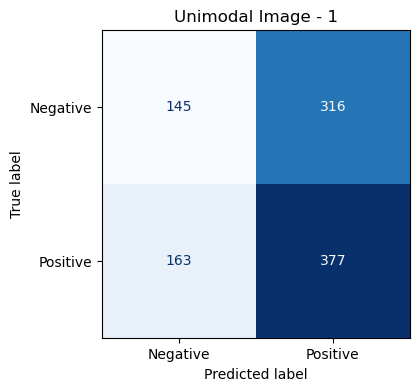


Unimodal Image - Class '2'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


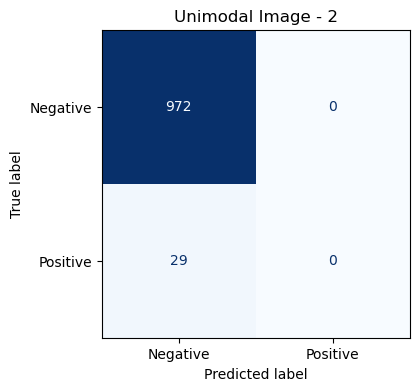


Unimodal Image - Class '3'
Confusion Matrix:
[[900   0]
 [101   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


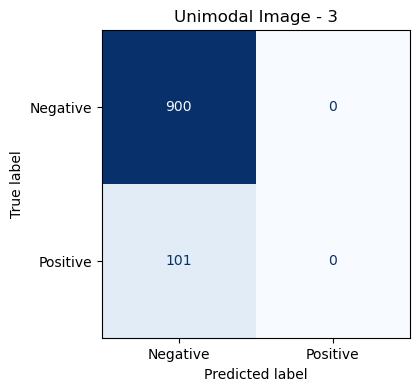


Unimodal Image - Class '4'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


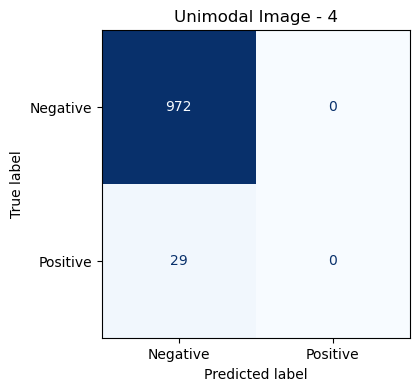


Unimodal Image - Class '5'
Confusion Matrix:
[[982   0]
 [ 19   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


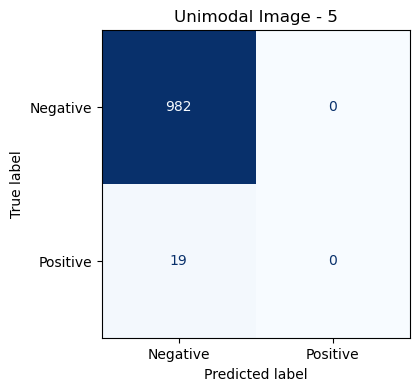


Unimodal Image - Class '6'
Confusion Matrix:
[[961   0]
 [ 40   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


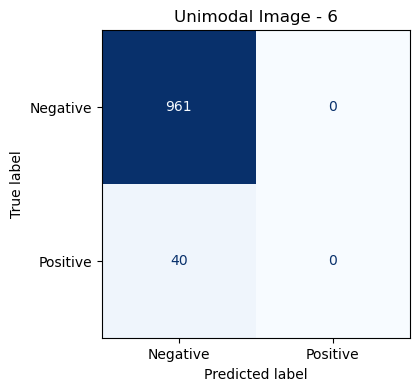


Unimodal Image - Class '7'
Confusion Matrix:
[[969   0]
 [ 32   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


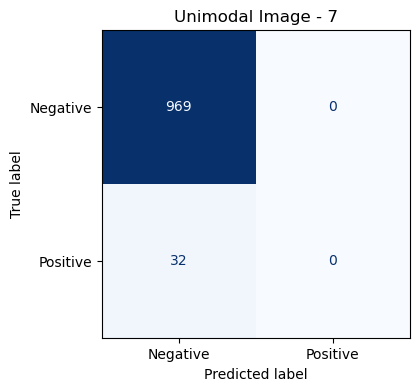


Unimodal Image - Class '8'
Confusion Matrix:
[[957   0]
 [ 44   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


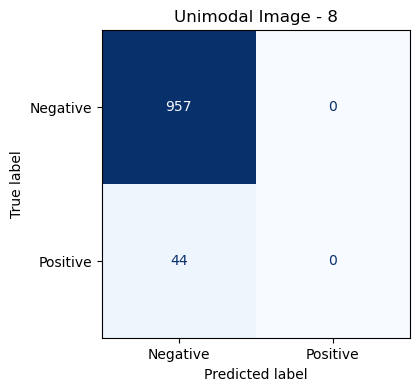


Unimodal Image - Class '9'
Confusion Matrix:
[[978   0]
 [ 23   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


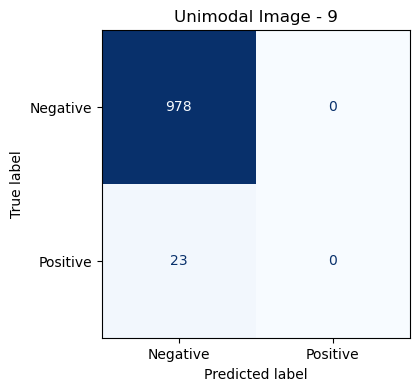


Unimodal Image - Class '10'
Confusion Matrix:
[[957   0]
 [ 44   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


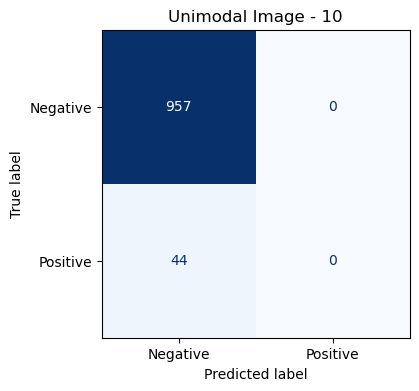


Unimodal Image - Class '11'
Confusion Matrix:
[[985   0]
 [ 16   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


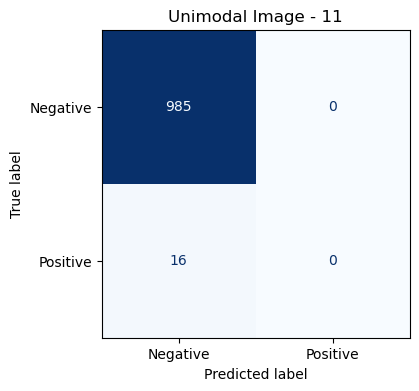


Unimodal Image - Class '13'
Confusion Matrix:
[[984   0]
 [ 17   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


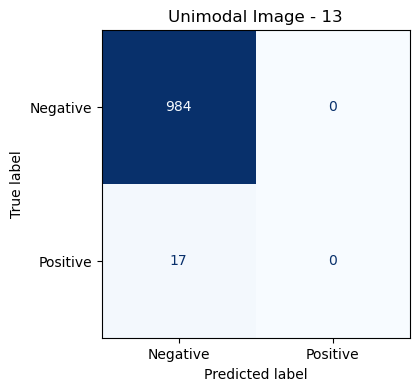


Unimodal Image - Class '14'
Confusion Matrix:
[[995   0]
 [  6   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


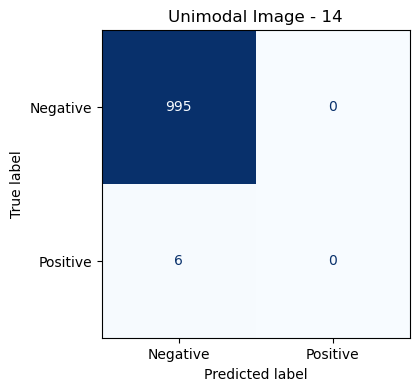


Unimodal Image - Class '15'
Confusion Matrix:
[[952   0]
 [ 49   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


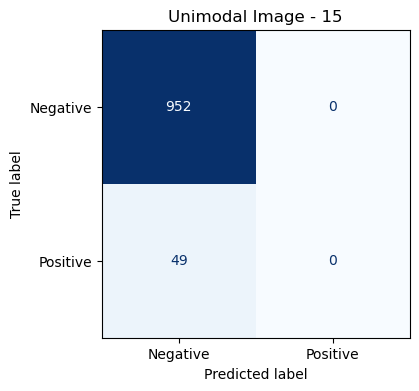


Unimodal Image - Class '16'
Confusion Matrix:
[[980   0]
 [ 21   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


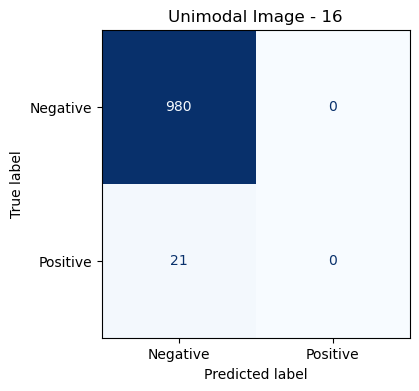


Unimodal Image - Class '17'
Confusion Matrix:
[[969   0]
 [ 32   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


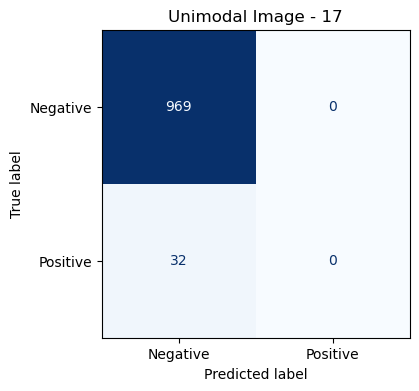


Unimodal Image - Class '18'
Confusion Matrix:
[[966   0]
 [ 35   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


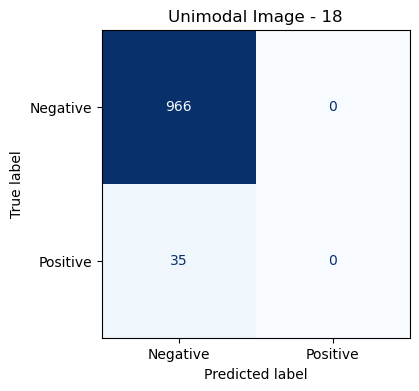


Unimodal Image - Class '19'
Confusion Matrix:
[[979   0]
 [ 22   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


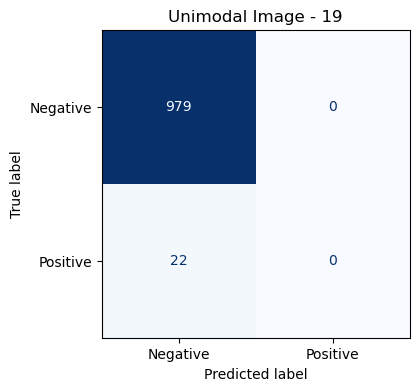


Unimodal Image - Class '20'
Confusion Matrix:
[[986   0]
 [ 15   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


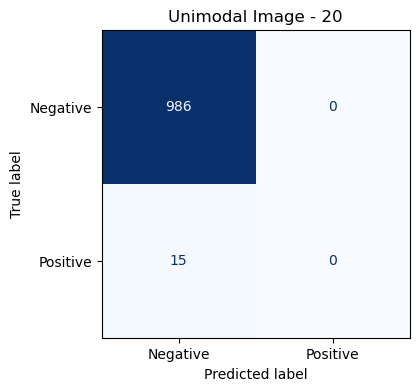


Unimodal Image - Class '21'
Confusion Matrix:
[[980   0]
 [ 21   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


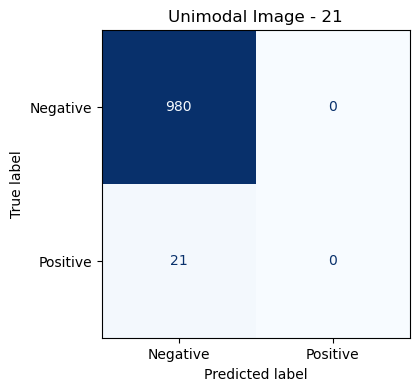


Unimodal Image - Class '22'
Confusion Matrix:
[[981   0]
 [ 20   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


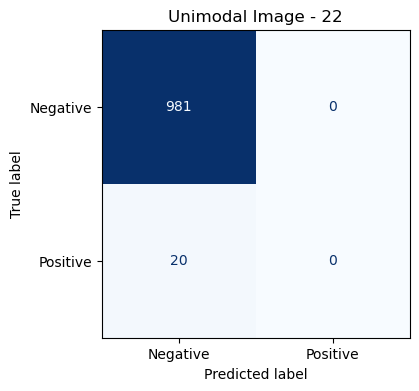


Unimodal Image - Class '23'
Confusion Matrix:
[[988   0]
 [ 13   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


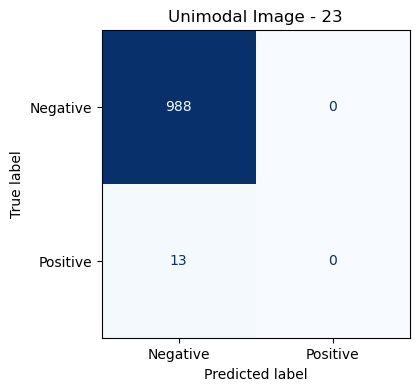


Unimodal Image - Class '24'
Confusion Matrix:
[[980   0]
 [ 21   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


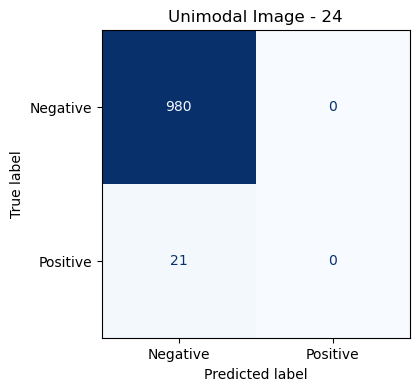


Unimodal Image - Class '25'
Confusion Matrix:
[[982   0]
 [ 19   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


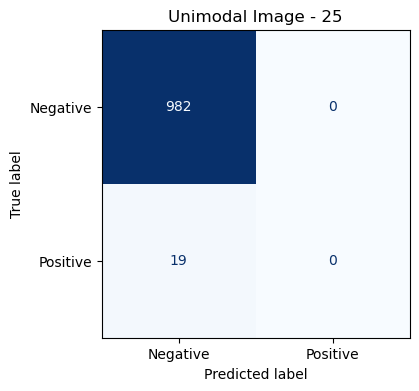


Unimodal Image - Class '27'
Confusion Matrix:
[[955   0]
 [ 46   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


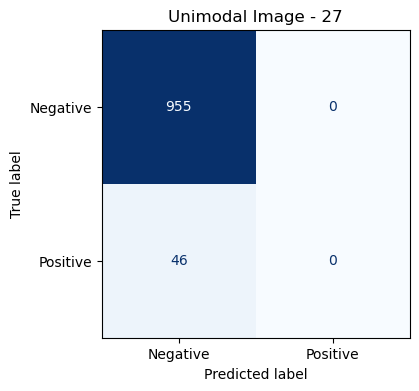


Unimodal Image - Class '28'
Confusion Matrix:
[[971   0]
 [ 30   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


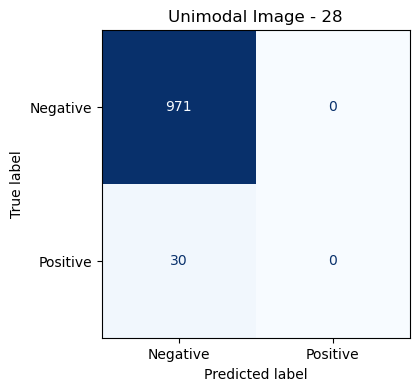


Unimodal Image - Class '31'
Confusion Matrix:
[[945   0]
 [ 56   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


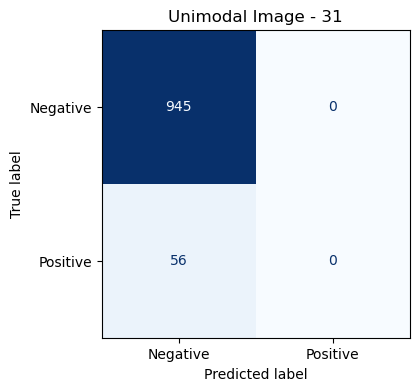


Unimodal Image - Class '32'
Confusion Matrix:
[[970   0]
 [ 31   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


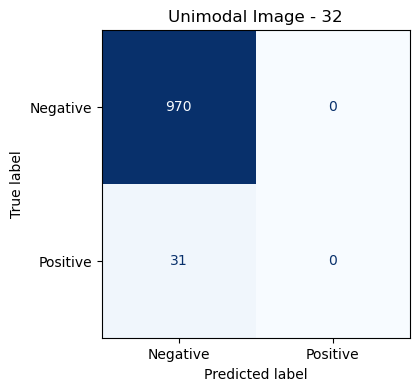


Unimodal Image - Class '33'
Confusion Matrix:
[[976   0]
 [ 25   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


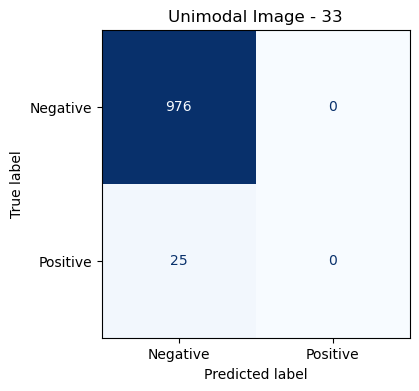


Unimodal Image - Class '34'
Confusion Matrix:
[[982   0]
 [ 19   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


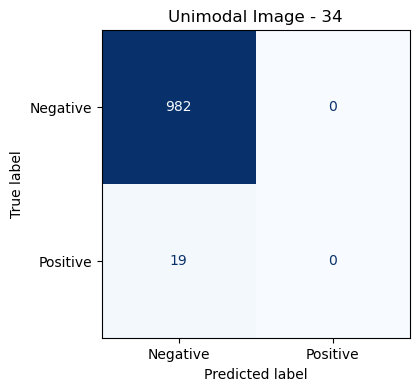


Unimodal Image - Class '35'
Confusion Matrix:
[[978   0]
 [ 23   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


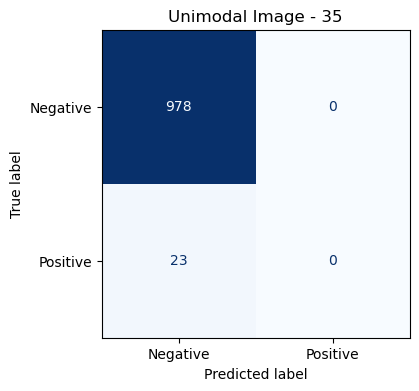


Unimodal Image - Class '36'
Confusion Matrix:
[[990   0]
 [ 11   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


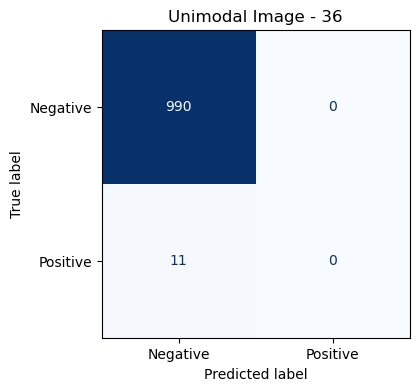


Unimodal Image - Class '37'
Confusion Matrix:
[[964   0]
 [ 37   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


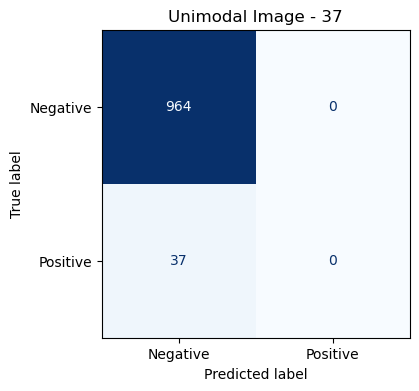


Unimodal Image - Class '38'
Confusion Matrix:
[[984   0]
 [ 17   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


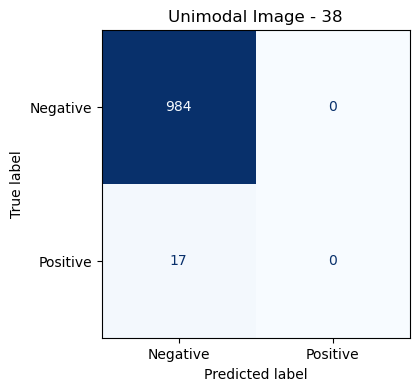


Unimodal Image - Class '39'
Confusion Matrix:
[[980   0]
 [ 21   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


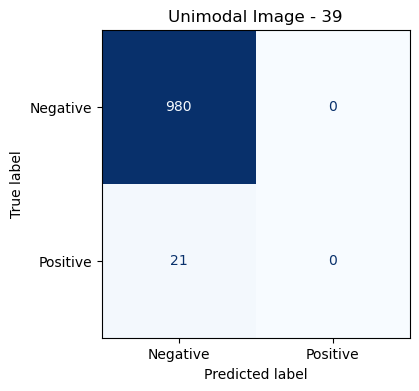


Unimodal Image - Class '40'
Confusion Matrix:
[[986   0]
 [ 15   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


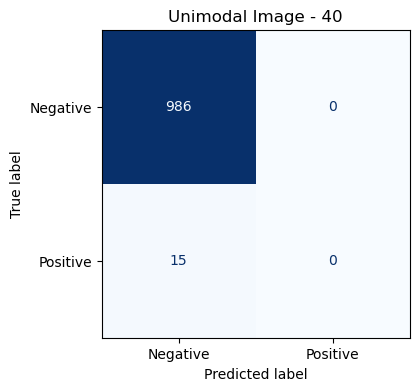


Unimodal Image - Class '41'
Confusion Matrix:
[[978   0]
 [ 23   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


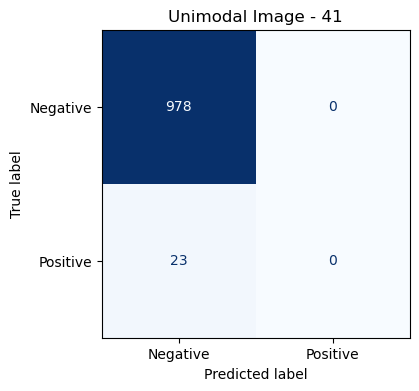


Unimodal Image - Class '42'
Confusion Matrix:
[[966   0]
 [ 35   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


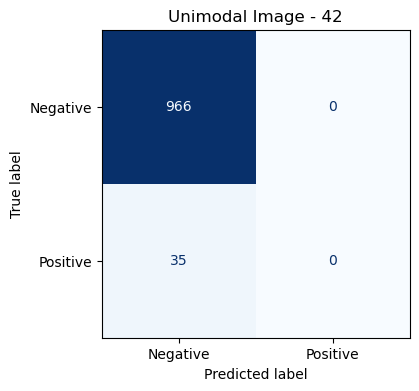


Unimodal Image - Class '43'
Confusion Matrix:
[[962   0]
 [ 39   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


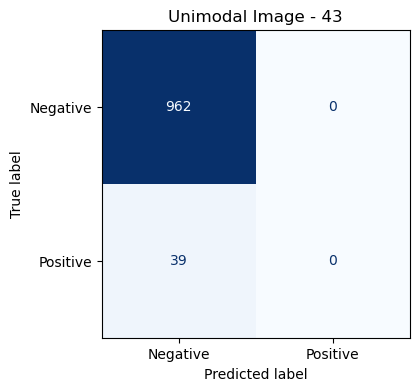


Unimodal Image - Class '44'
Confusion Matrix:
[[933   0]
 [ 68   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


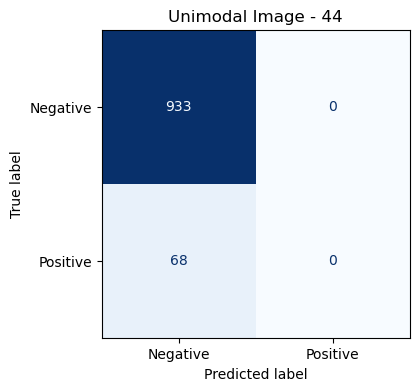


Unimodal Image - Class '46'
Confusion Matrix:
[[983   0]
 [ 18   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


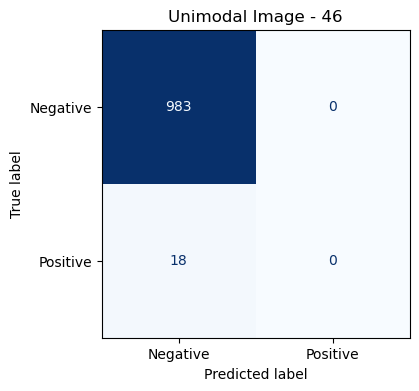


Unimodal Image - Class '47'
Confusion Matrix:
[[922   0]
 [ 79   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


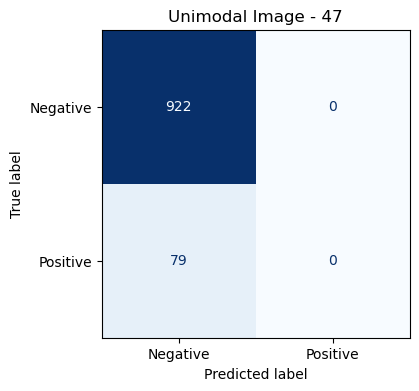


Unimodal Image - Class '48'
Confusion Matrix:
[[974   0]
 [ 27   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


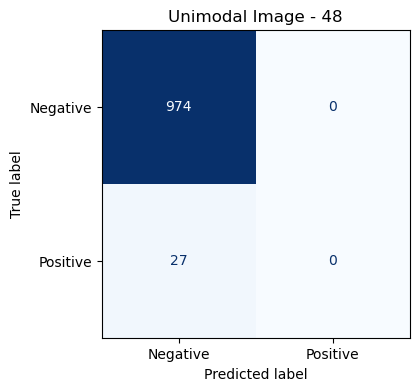


Unimodal Image - Class '49'
Confusion Matrix:
[[965   0]
 [ 36   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


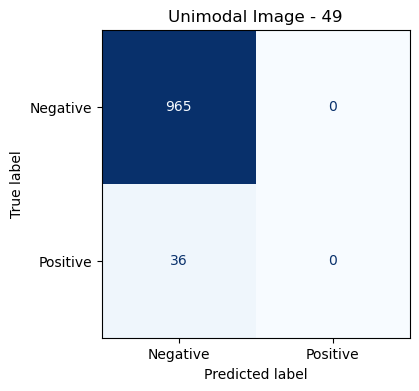


Unimodal Image - Class '50'
Confusion Matrix:
[[969   0]
 [ 32   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


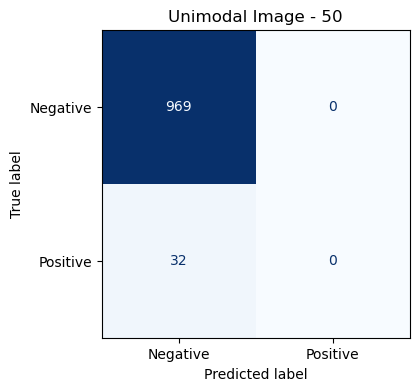


Unimodal Image - Class '51'
Confusion Matrix:
[[934   0]
 [ 67   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


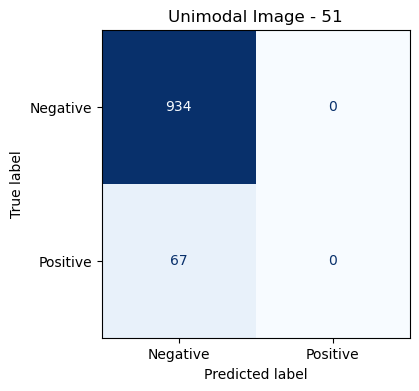


Unimodal Image - Class '52'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


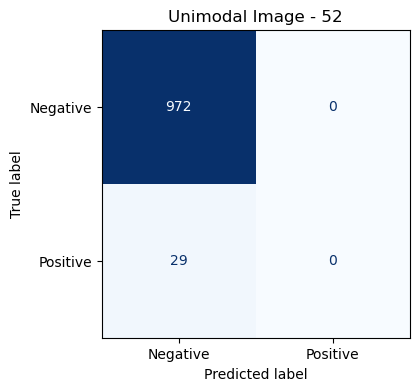


Unimodal Image - Class '53'
Confusion Matrix:
[[984   0]
 [ 17   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


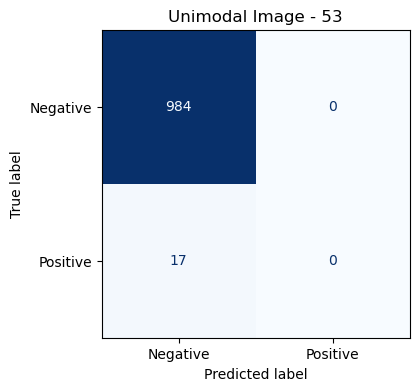


Unimodal Image - Class '54'
Confusion Matrix:
[[979   0]
 [ 22   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


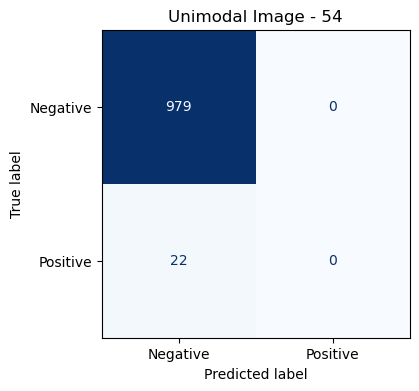


Unimodal Image - Class '55'
Confusion Matrix:
[[983   0]
 [ 18   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


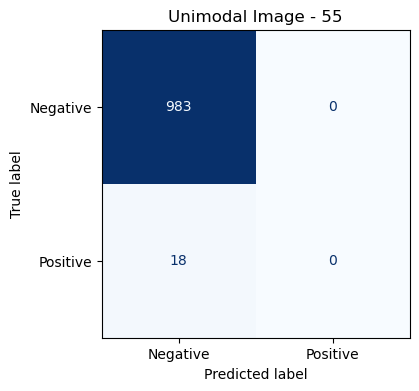


Unimodal Image - Class '56'
Confusion Matrix:
[[989   0]
 [ 12   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


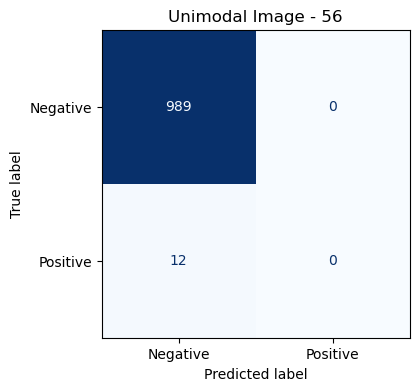


Unimodal Image - Class '57'
Confusion Matrix:
[[981   0]
 [ 20   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


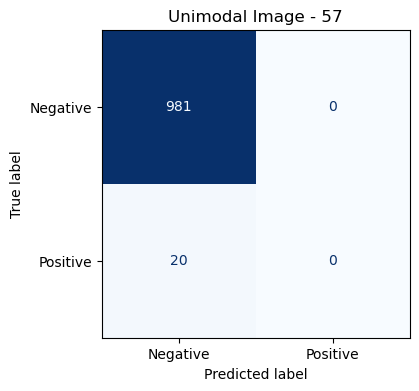


Unimodal Image - Class '58'
Confusion Matrix:
[[991   0]
 [ 10   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


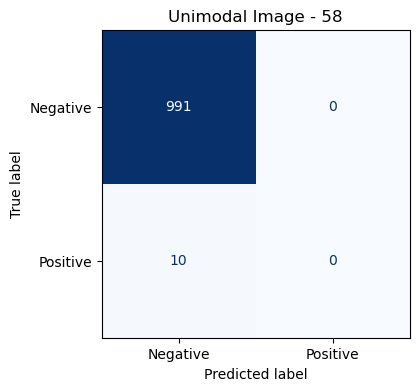


Unimodal Image - Class '59'
Confusion Matrix:
[[966   0]
 [ 35   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


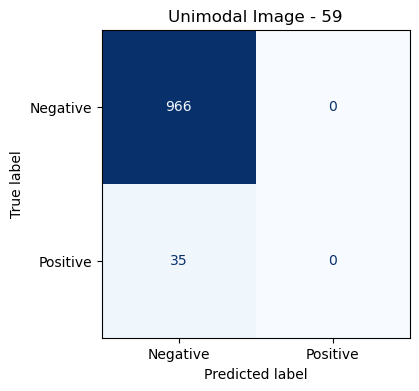


Unimodal Image - Class '60'
Confusion Matrix:
[[987   0]
 [ 14   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


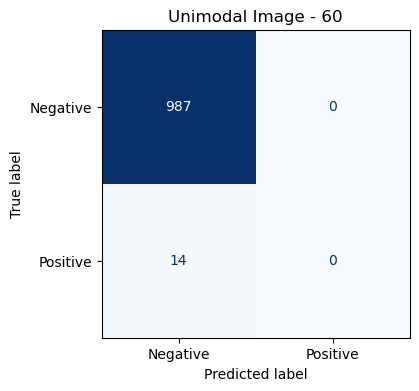


Unimodal Image - Class '61'
Confusion Matrix:
[[973   0]
 [ 28   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


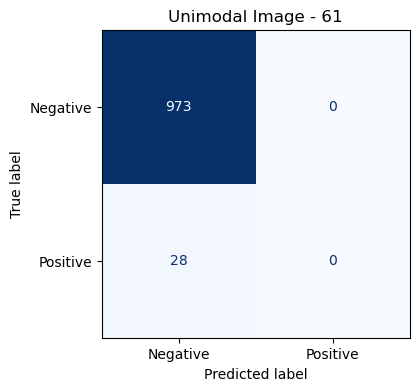


Unimodal Image - Class '62'
Confusion Matrix:
[[886   0]
 [115   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


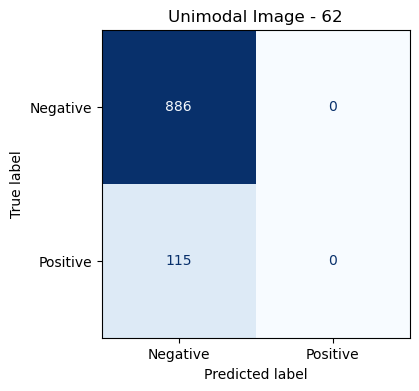


Unimodal Image - Class '63'
Confusion Matrix:
[[966   0]
 [ 35   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


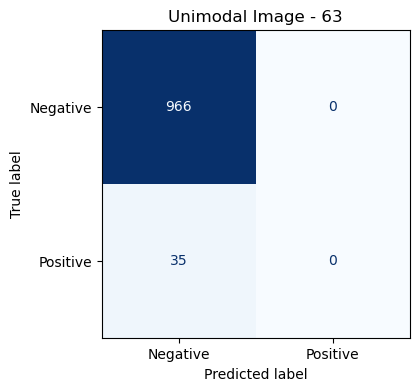


Unimodal Image - Class '64'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


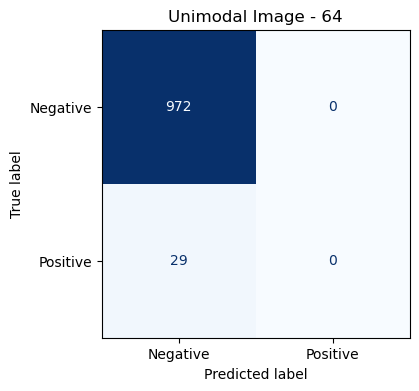


Unimodal Image - Class '65'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


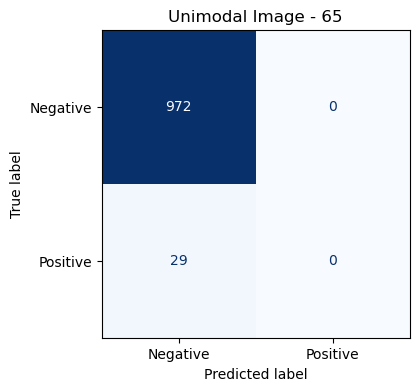


Unimodal Image - Class '67'
Confusion Matrix:
[[903   0]
 [ 98   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


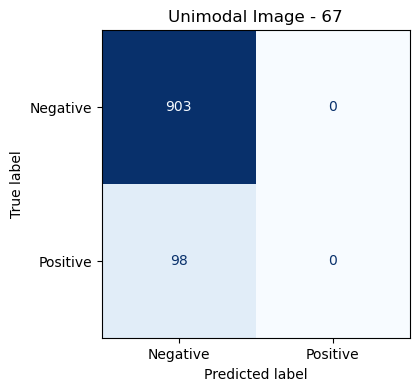


Unimodal Image - Class '70'
Confusion Matrix:
[[977   0]
 [ 24   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


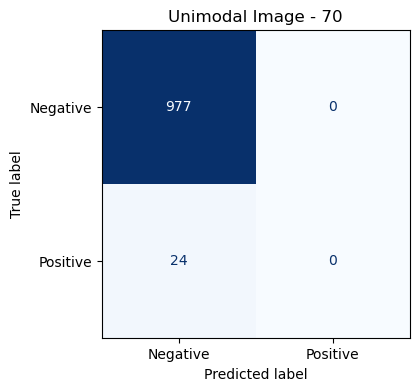


Unimodal Image - Class '72'
Confusion Matrix:
[[962   0]
 [ 39   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


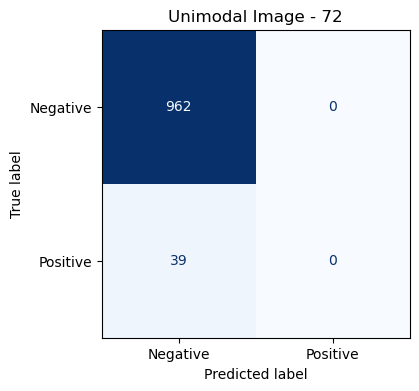


Unimodal Image - Class '73'
Confusion Matrix:
[[974   0]
 [ 27   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


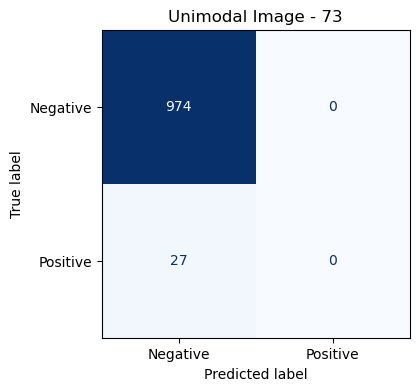


Unimodal Image - Class '74'
Confusion Matrix:
[[988   0]
 [ 13   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


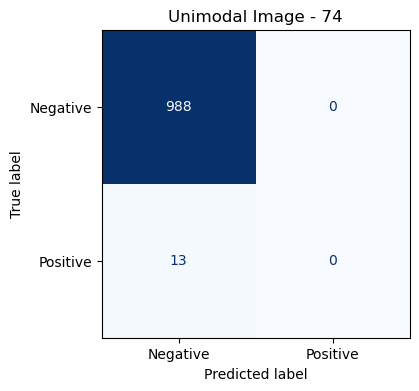


Unimodal Image - Class '75'
Confusion Matrix:
[[977   0]
 [ 24   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


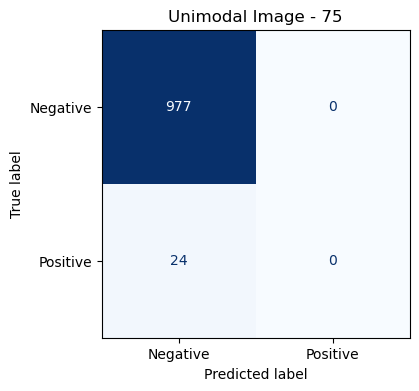


Unimodal Image - Class '76'
Confusion Matrix:
[[986   0]
 [ 15   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


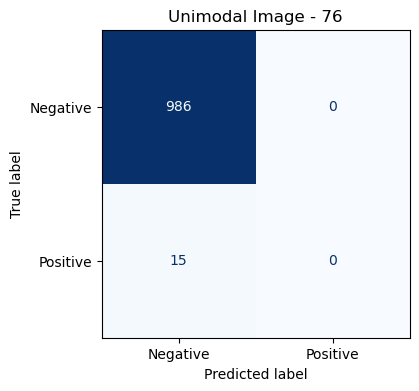


Unimodal Image - Class '77'
Confusion Matrix:
[[964   0]
 [ 37   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


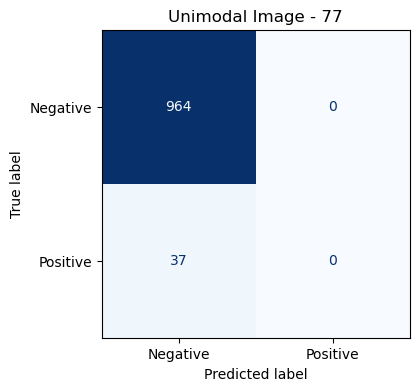


Unimodal Image - Class '78'
Confusion Matrix:
[[991   0]
 [ 10   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


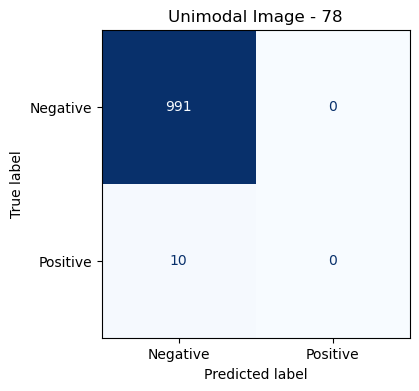


Unimodal Image - Class '79'
Confusion Matrix:
[[974   0]
 [ 27   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


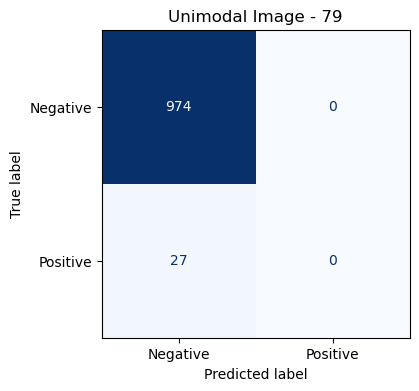


Unimodal Image - Class '80'
Confusion Matrix:
[[1000    0]
 [   1    0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


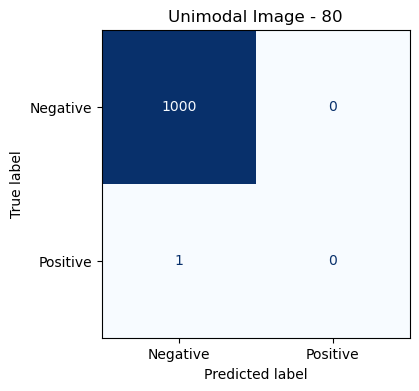


Unimodal Image - Class '81'
Confusion Matrix:
[[974   0]
 [ 27   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


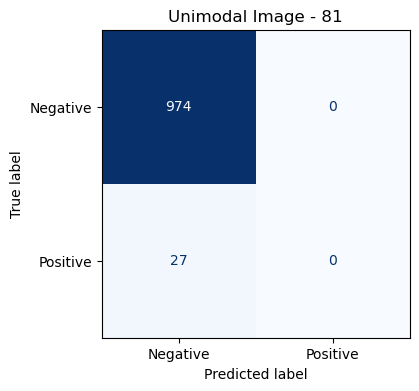


Unimodal Image - Class '82'
Confusion Matrix:
[[984   0]
 [ 17   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


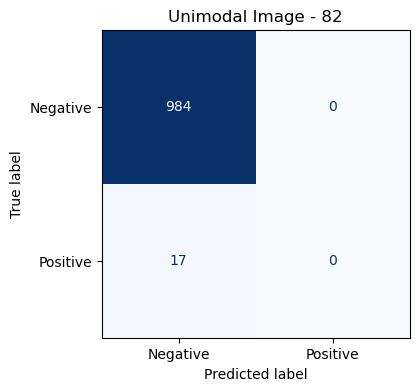


Unimodal Image - Class '84'
Confusion Matrix:
[[960   0]
 [ 41   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


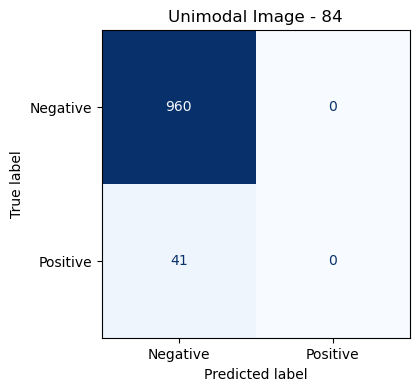


Unimodal Image - Class '85'
Confusion Matrix:
[[960   0]
 [ 41   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


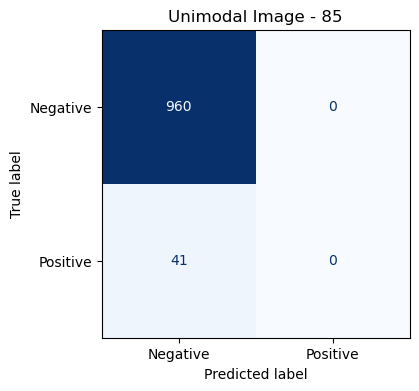


Unimodal Image - Class '86'
Confusion Matrix:
[[968   0]
 [ 33   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


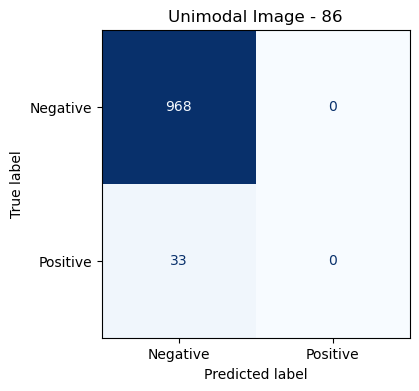


Unimodal Image - Class '87'
Confusion Matrix:
[[996   0]
 [  5   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


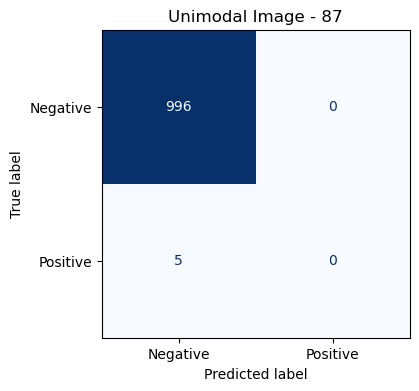


Unimodal Image - Class '88'
Confusion Matrix:
[[987   0]
 [ 14   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


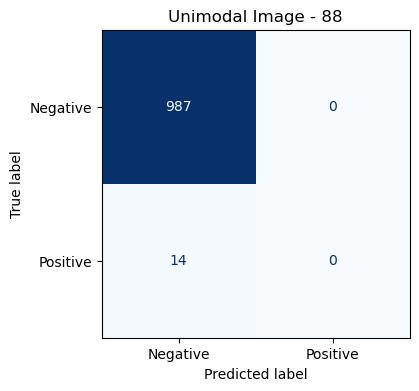


Unimodal Image - Class '89'
Confusion Matrix:
[[1001    0]
 [   0    0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


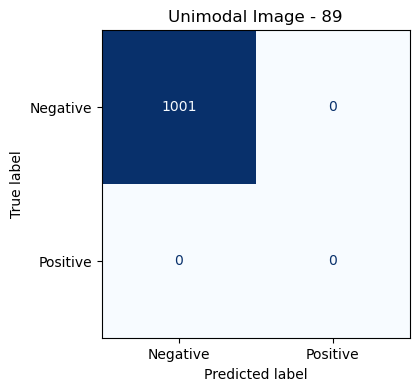


Unimodal Image - Class '90'
Confusion Matrix:
[[993   0]
 [  8   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


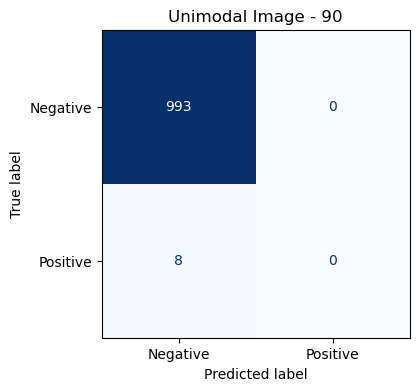


=== Unimodal Text ===

Unimodal Text - Class '1'
Confusion Matrix:
[[403  58]
 [ 88 452]]
Precision: 0.8863, Recall: 0.8370, F1-score: 0.8610


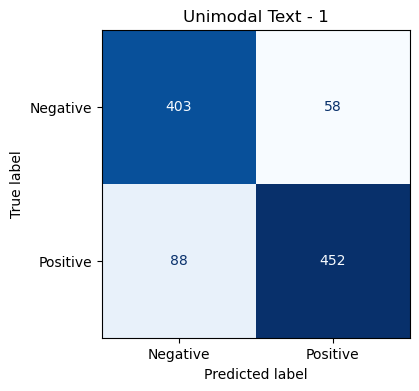


Unimodal Text - Class '2'
Confusion Matrix:
[[971   1]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


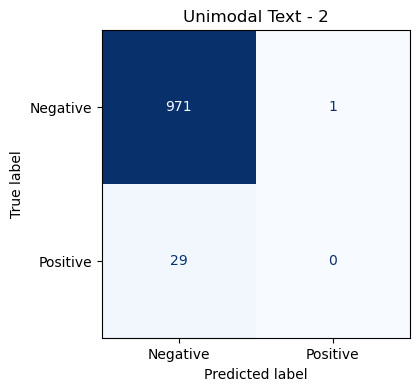


Unimodal Text - Class '3'
Confusion Matrix:
[[877  23]
 [ 66  35]]
Precision: 0.6034, Recall: 0.3465, F1-score: 0.4403


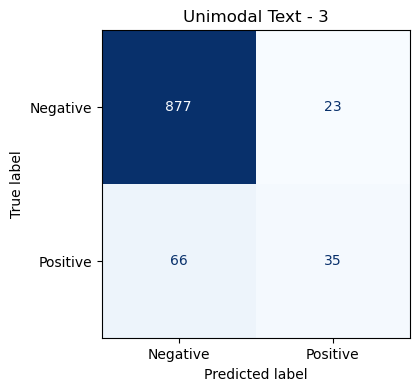


Unimodal Text - Class '4'
Confusion Matrix:
[[972   0]
 [ 27   2]]
Precision: 1.0000, Recall: 0.0690, F1-score: 0.1290


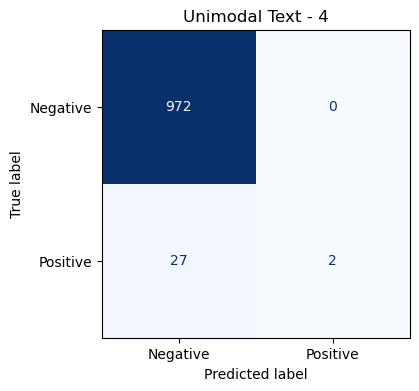


Unimodal Text - Class '5'
Confusion Matrix:
[[981   1]
 [ 13   6]]
Precision: 0.8571, Recall: 0.3158, F1-score: 0.4615


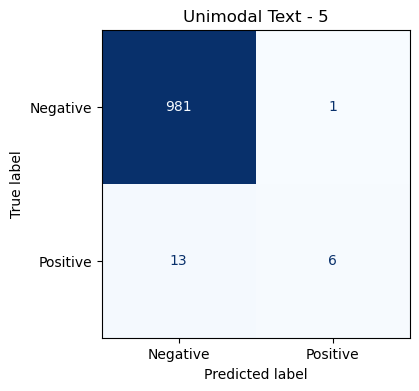


Unimodal Text - Class '6'
Confusion Matrix:
[[958   3]
 [ 26  14]]
Precision: 0.8235, Recall: 0.3500, F1-score: 0.4912


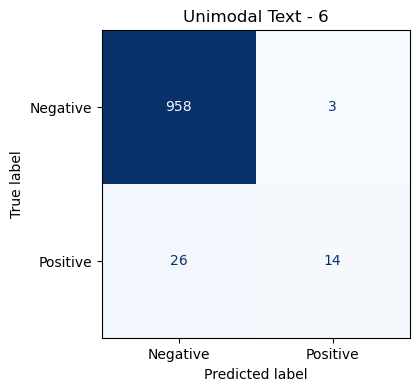


Unimodal Text - Class '7'
Confusion Matrix:
[[969   0]
 [  5  27]]
Precision: 1.0000, Recall: 0.8438, F1-score: 0.9153


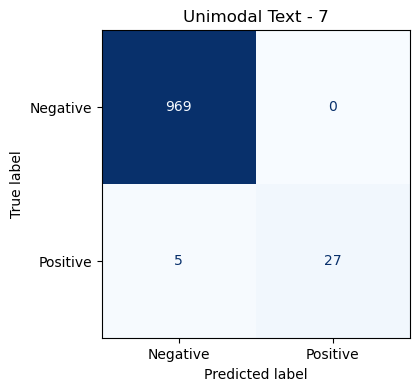


Unimodal Text - Class '8'
Confusion Matrix:
[[954   3]
 [ 43   1]]
Precision: 0.2500, Recall: 0.0227, F1-score: 0.0417


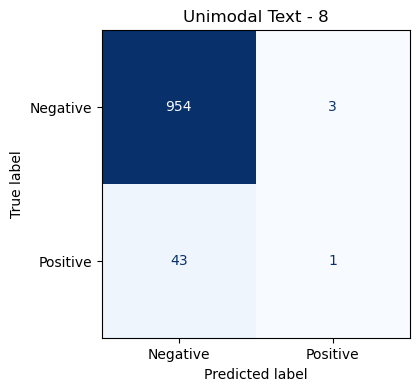


Unimodal Text - Class '9'
Confusion Matrix:
[[978   0]
 [ 23   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


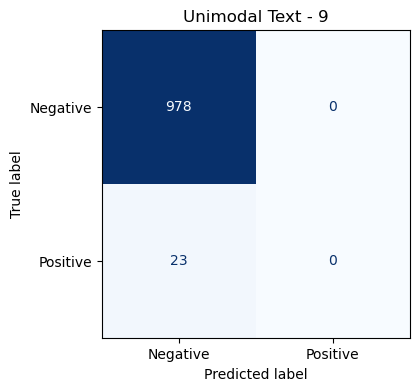


Unimodal Text - Class '10'
Confusion Matrix:
[[949   8]
 [ 35   9]]
Precision: 0.5294, Recall: 0.2045, F1-score: 0.2951


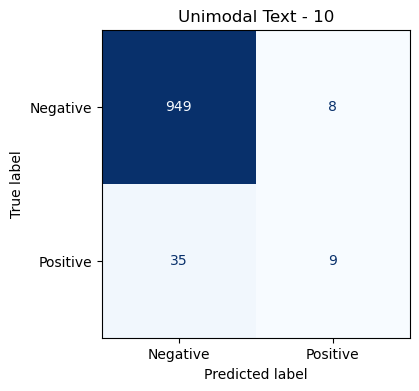


Unimodal Text - Class '11'
Confusion Matrix:
[[985   0]
 [ 12   4]]
Precision: 1.0000, Recall: 0.2500, F1-score: 0.4000


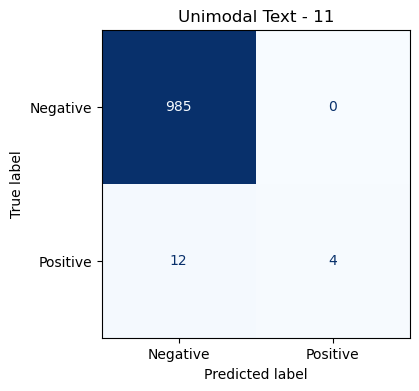


Unimodal Text - Class '13'
Confusion Matrix:
[[983   1]
 [ 13   4]]
Precision: 0.8000, Recall: 0.2353, F1-score: 0.3636


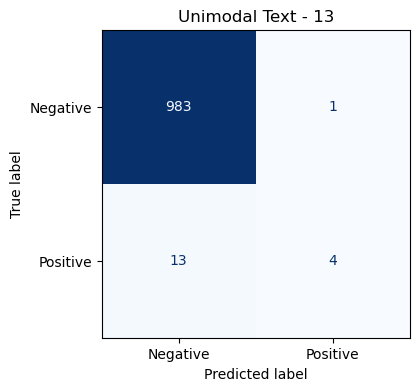


Unimodal Text - Class '14'
Confusion Matrix:
[[995   0]
 [  5   1]]
Precision: 1.0000, Recall: 0.1667, F1-score: 0.2857


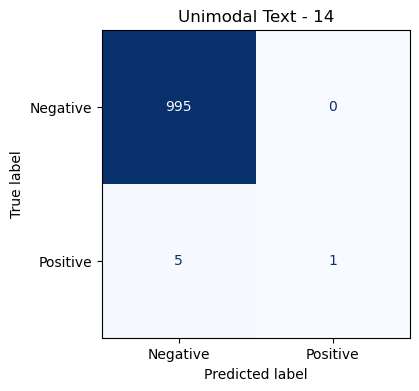


Unimodal Text - Class '15'
Confusion Matrix:
[[951   1]
 [ 45   4]]
Precision: 0.8000, Recall: 0.0816, F1-score: 0.1481


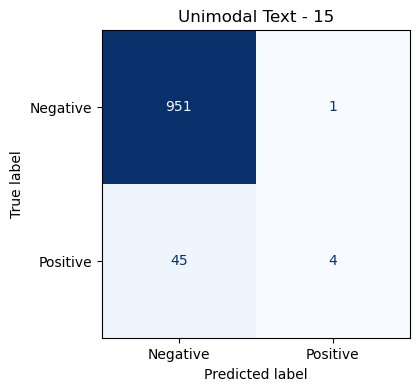


Unimodal Text - Class '16'
Confusion Matrix:
[[980   0]
 [ 21   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


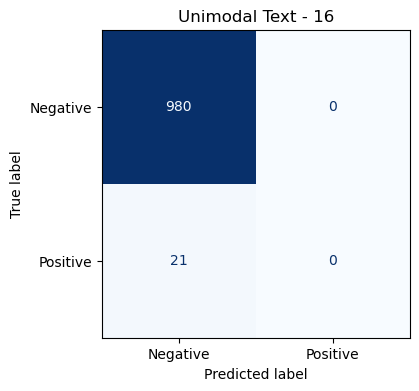


Unimodal Text - Class '17'
Confusion Matrix:
[[968   1]
 [ 20  12]]
Precision: 0.9231, Recall: 0.3750, F1-score: 0.5333


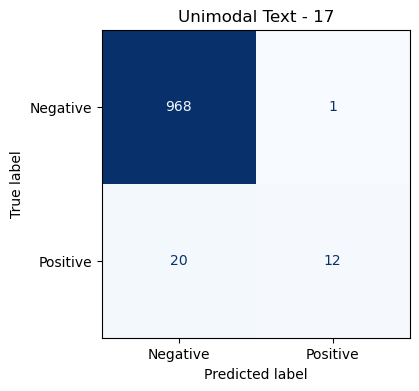


Unimodal Text - Class '18'
Confusion Matrix:
[[966   0]
 [ 31   4]]
Precision: 1.0000, Recall: 0.1143, F1-score: 0.2051


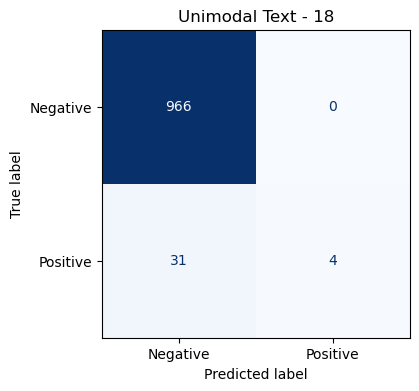


Unimodal Text - Class '19'
Confusion Matrix:
[[978   1]
 [ 21   1]]
Precision: 0.5000, Recall: 0.0455, F1-score: 0.0833


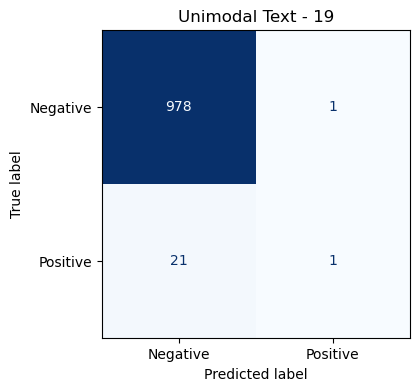


Unimodal Text - Class '20'
Confusion Matrix:
[[986   0]
 [ 15   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


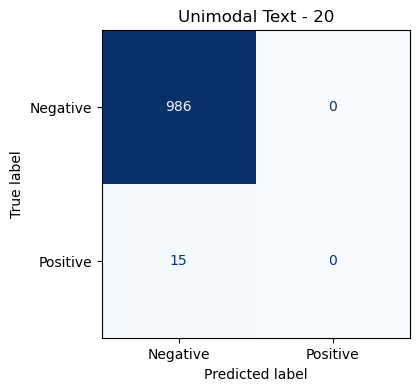


Unimodal Text - Class '21'
Confusion Matrix:
[[979   1]
 [ 21   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


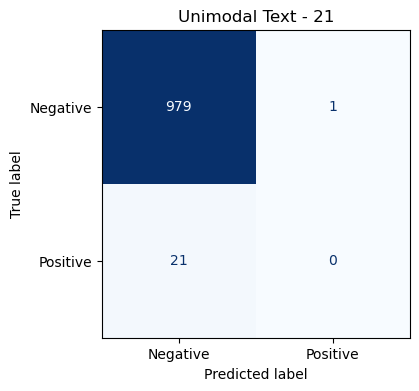


Unimodal Text - Class '22'
Confusion Matrix:
[[981   0]
 [ 19   1]]
Precision: 1.0000, Recall: 0.0500, F1-score: 0.0952


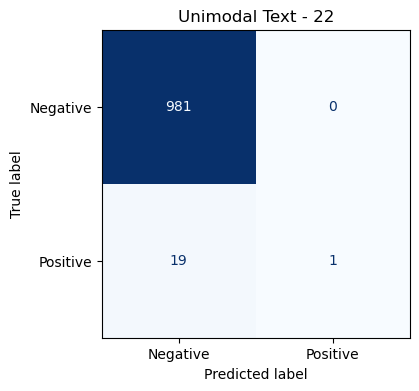


Unimodal Text - Class '23'
Confusion Matrix:
[[988   0]
 [ 13   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


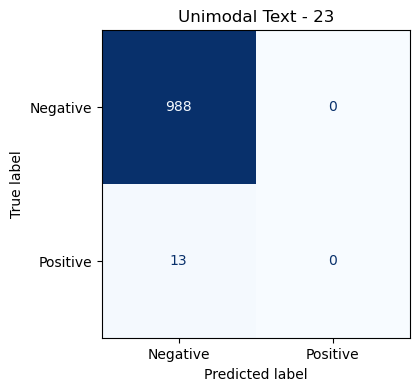


Unimodal Text - Class '24'
Confusion Matrix:
[[978   2]
 [ 17   4]]
Precision: 0.6667, Recall: 0.1905, F1-score: 0.2963


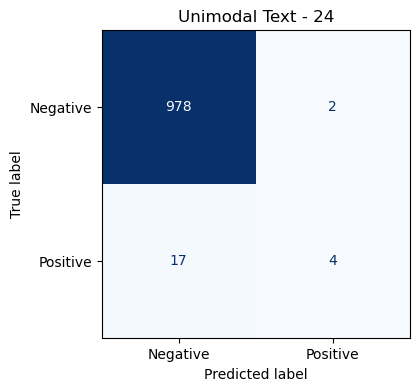


Unimodal Text - Class '25'
Confusion Matrix:
[[979   3]
 [ 16   3]]
Precision: 0.5000, Recall: 0.1579, F1-score: 0.2400


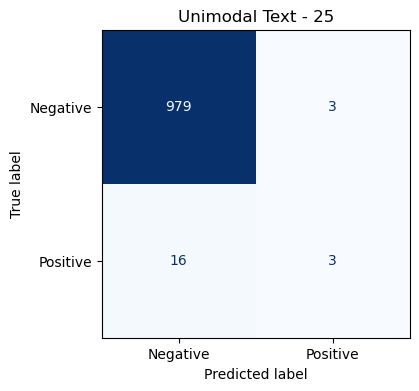


Unimodal Text - Class '27'
Confusion Matrix:
[[953   2]
 [ 45   1]]
Precision: 0.3333, Recall: 0.0217, F1-score: 0.0408


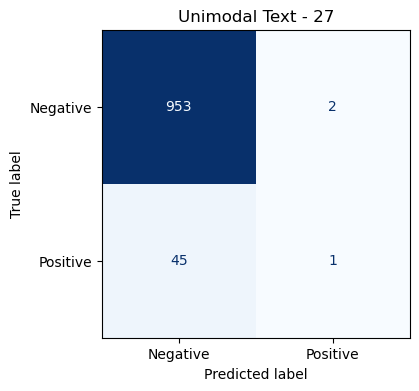


Unimodal Text - Class '28'
Confusion Matrix:
[[970   1]
 [ 26   4]]
Precision: 0.8000, Recall: 0.1333, F1-score: 0.2286


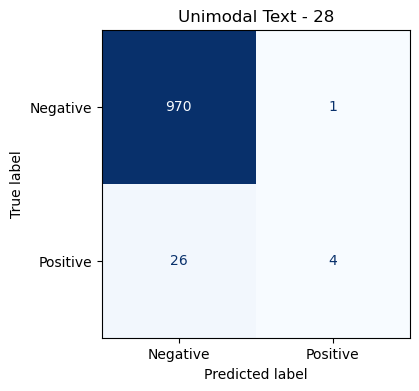


Unimodal Text - Class '31'
Confusion Matrix:
[[942   3]
 [ 54   2]]
Precision: 0.4000, Recall: 0.0357, F1-score: 0.0656


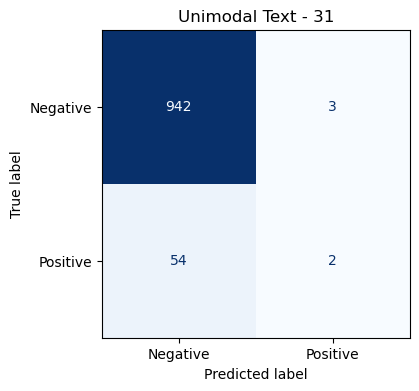


Unimodal Text - Class '32'
Confusion Matrix:
[[969   1]
 [ 23   8]]
Precision: 0.8889, Recall: 0.2581, F1-score: 0.4000


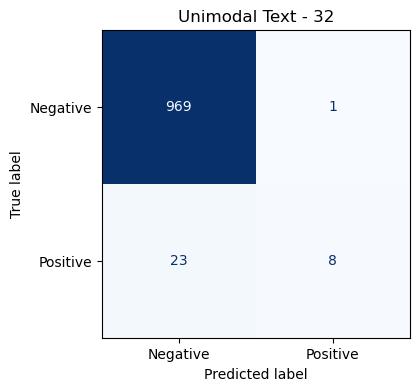


Unimodal Text - Class '33'
Confusion Matrix:
[[976   0]
 [ 24   1]]
Precision: 1.0000, Recall: 0.0400, F1-score: 0.0769


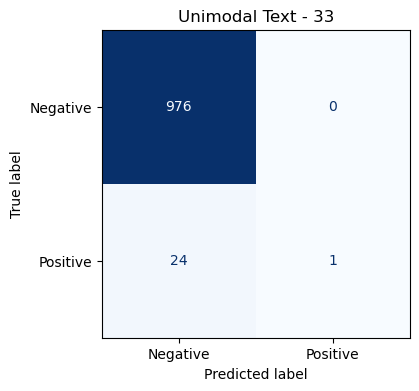


Unimodal Text - Class '34'
Confusion Matrix:
[[981   1]
 [ 14   5]]
Precision: 0.8333, Recall: 0.2632, F1-score: 0.4000


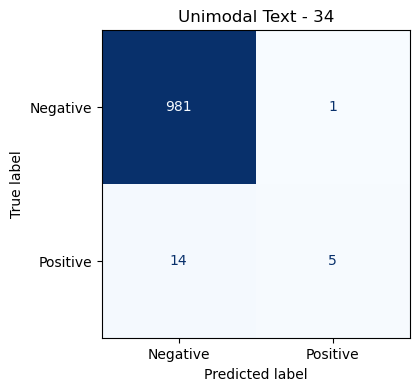


Unimodal Text - Class '35'
Confusion Matrix:
[[976   2]
 [ 16   7]]
Precision: 0.7778, Recall: 0.3043, F1-score: 0.4375


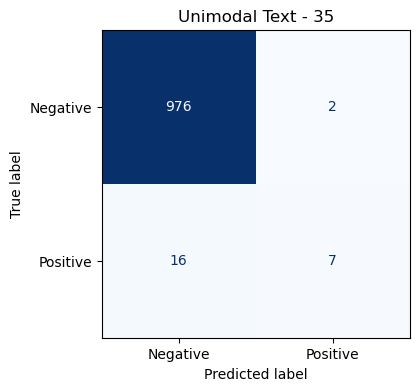


Unimodal Text - Class '36'
Confusion Matrix:
[[990   0]
 [ 11   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


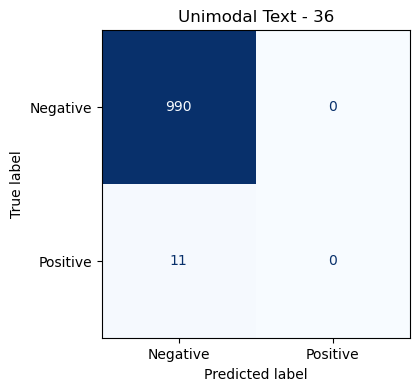


Unimodal Text - Class '37'
Confusion Matrix:
[[949  15]
 [ 23  14]]
Precision: 0.4828, Recall: 0.3784, F1-score: 0.4242


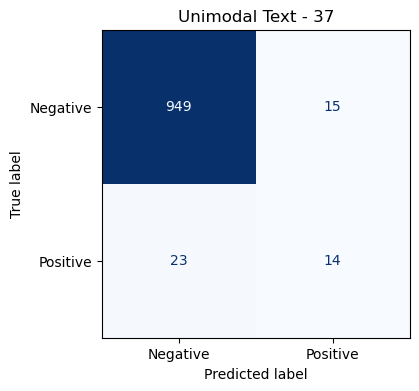


Unimodal Text - Class '38'
Confusion Matrix:
[[984   0]
 [ 13   4]]
Precision: 1.0000, Recall: 0.2353, F1-score: 0.3810


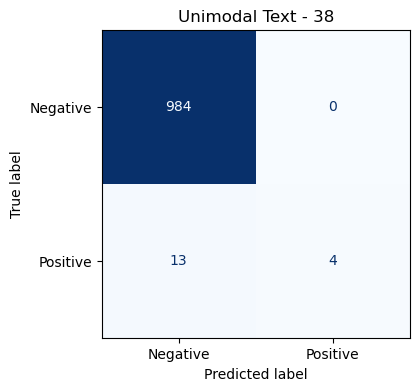


Unimodal Text - Class '39'
Confusion Matrix:
[[979   1]
 [  9  12]]
Precision: 0.9231, Recall: 0.5714, F1-score: 0.7059


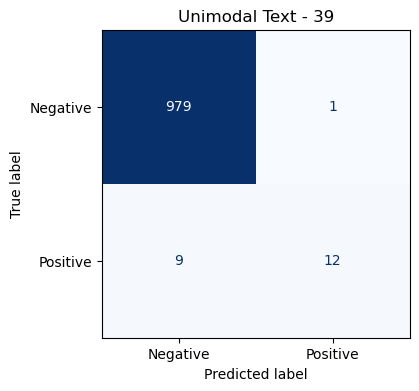


Unimodal Text - Class '40'
Confusion Matrix:
[[981   5]
 [  7   8]]
Precision: 0.6154, Recall: 0.5333, F1-score: 0.5714


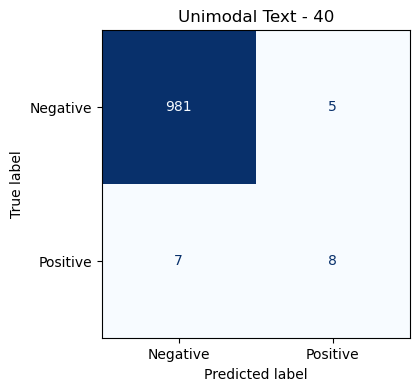


Unimodal Text - Class '41'
Confusion Matrix:
[[978   0]
 [  8  15]]
Precision: 1.0000, Recall: 0.6522, F1-score: 0.7895


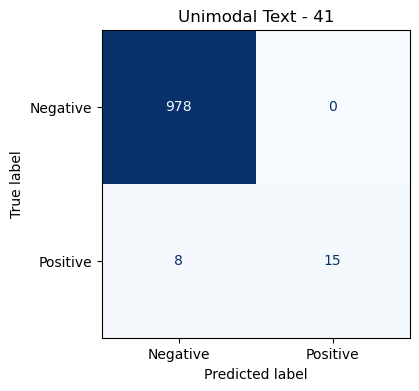


Unimodal Text - Class '42'
Confusion Matrix:
[[965   1]
 [ 24  11]]
Precision: 0.9167, Recall: 0.3143, F1-score: 0.4681


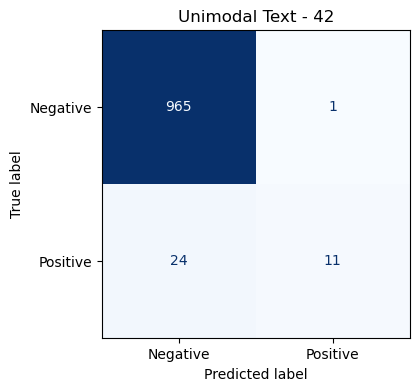


Unimodal Text - Class '43'
Confusion Matrix:
[[962   0]
 [  6  33]]
Precision: 1.0000, Recall: 0.8462, F1-score: 0.9167


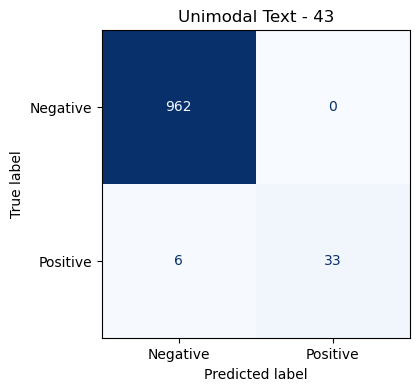


Unimodal Text - Class '44'
Confusion Matrix:
[[930   3]
 [ 65   3]]
Precision: 0.5000, Recall: 0.0441, F1-score: 0.0811


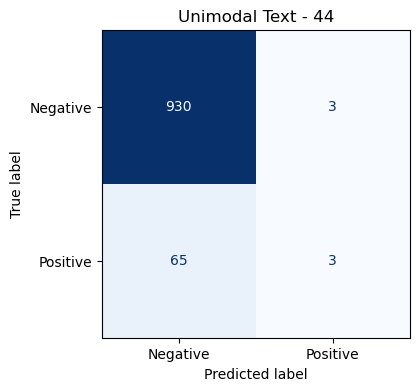


Unimodal Text - Class '46'
Confusion Matrix:
[[982   1]
 [ 16   2]]
Precision: 0.6667, Recall: 0.1111, F1-score: 0.1905


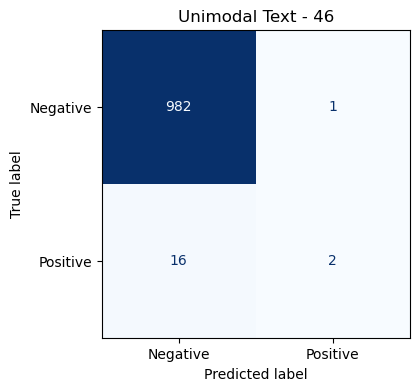


Unimodal Text - Class '47'
Confusion Matrix:
[[918   4]
 [ 70   9]]
Precision: 0.6923, Recall: 0.1139, F1-score: 0.1957


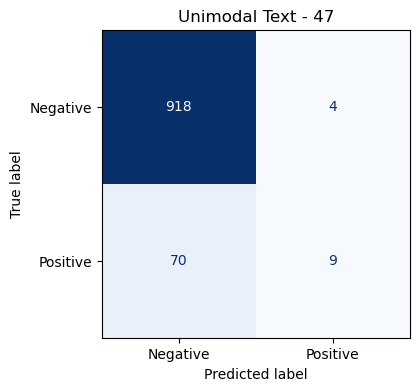


Unimodal Text - Class '48'
Confusion Matrix:
[[971   3]
 [ 22   5]]
Precision: 0.6250, Recall: 0.1852, F1-score: 0.2857


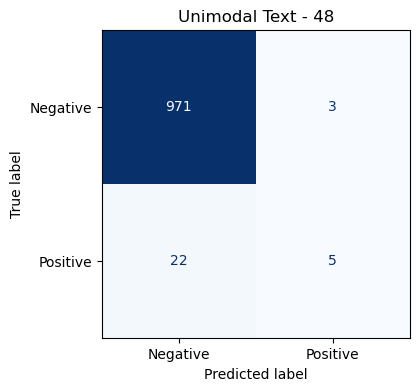


Unimodal Text - Class '49'
Confusion Matrix:
[[963   2]
 [ 34   2]]
Precision: 0.5000, Recall: 0.0556, F1-score: 0.1000


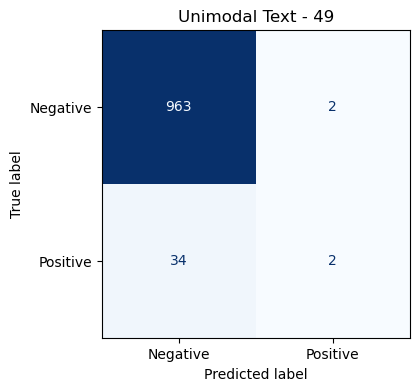


Unimodal Text - Class '50'
Confusion Matrix:
[[967   2]
 [ 32   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


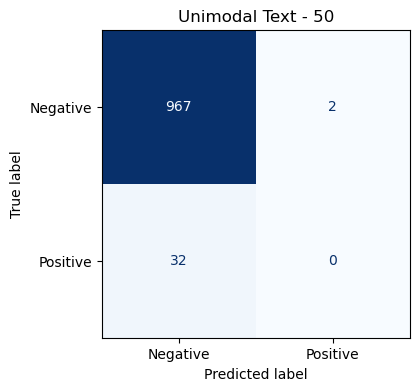


Unimodal Text - Class '51'
Confusion Matrix:
[[929   5]
 [ 53  14]]
Precision: 0.7368, Recall: 0.2090, F1-score: 0.3256


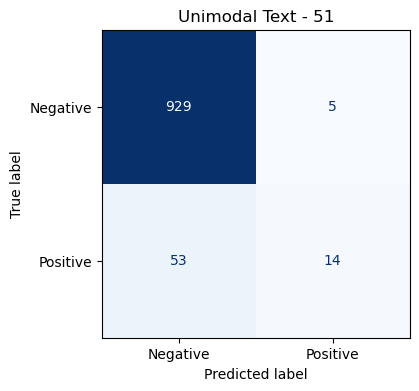


Unimodal Text - Class '52'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


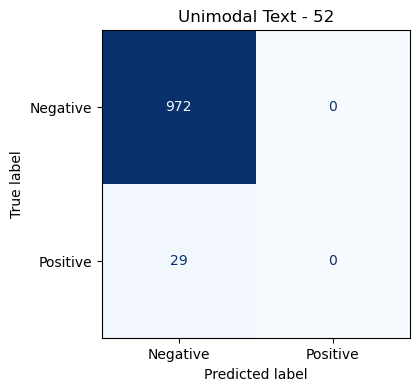


Unimodal Text - Class '53'
Confusion Matrix:
[[984   0]
 [ 17   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


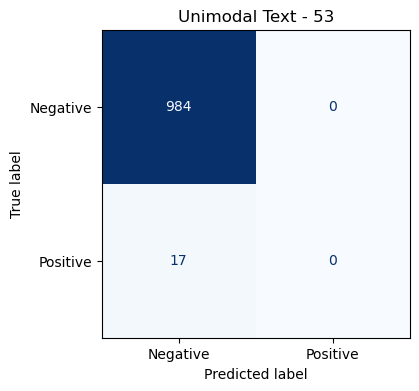


Unimodal Text - Class '54'
Confusion Matrix:
[[979   0]
 [ 22   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


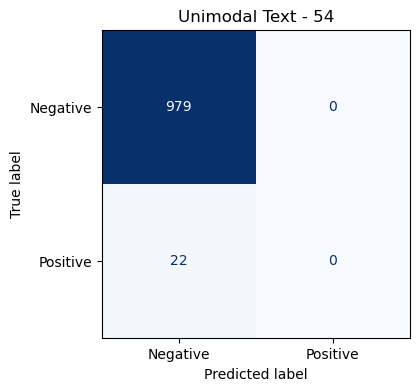


Unimodal Text - Class '55'
Confusion Matrix:
[[983   0]
 [ 18   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


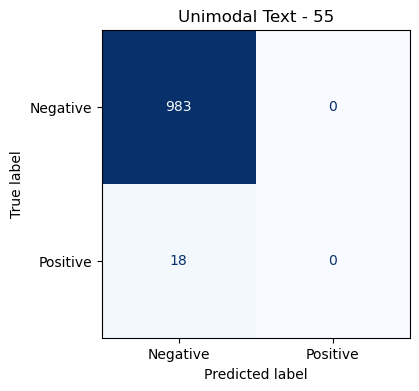


Unimodal Text - Class '56'
Confusion Matrix:
[[989   0]
 [ 10   2]]
Precision: 1.0000, Recall: 0.1667, F1-score: 0.2857


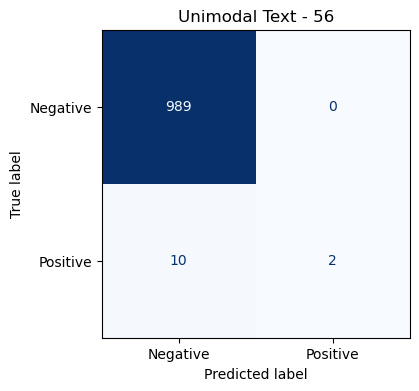


Unimodal Text - Class '57'
Confusion Matrix:
[[981   0]
 [ 20   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


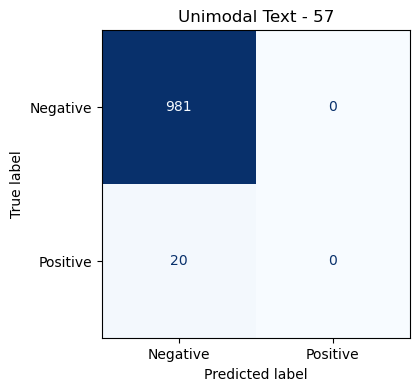


Unimodal Text - Class '58'
Confusion Matrix:
[[991   0]
 [ 10   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


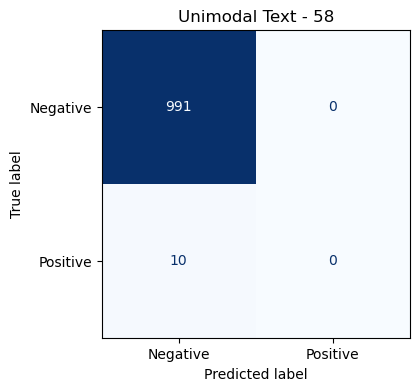


Unimodal Text - Class '59'
Confusion Matrix:
[[965   1]
 [ 29   6]]
Precision: 0.8571, Recall: 0.1714, F1-score: 0.2857


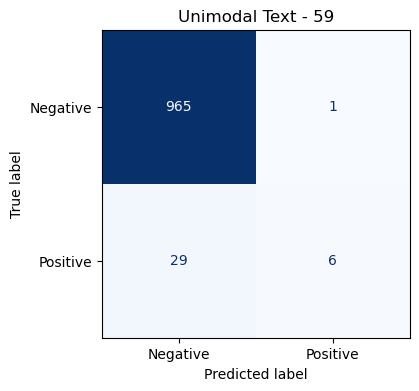


Unimodal Text - Class '60'
Confusion Matrix:
[[987   0]
 [ 14   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


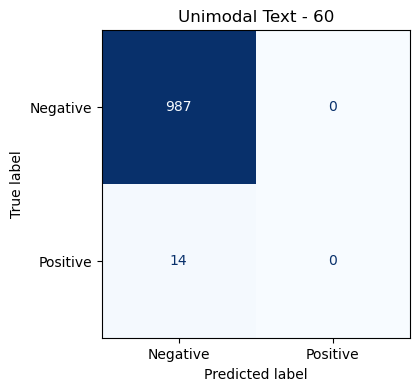


Unimodal Text - Class '61'
Confusion Matrix:
[[973   0]
 [ 28   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


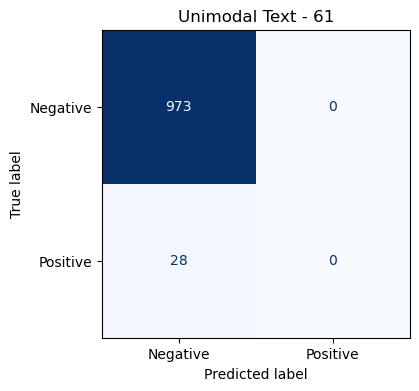


Unimodal Text - Class '62'
Confusion Matrix:
[[867  19]
 [ 90  25]]
Precision: 0.5682, Recall: 0.2174, F1-score: 0.3145


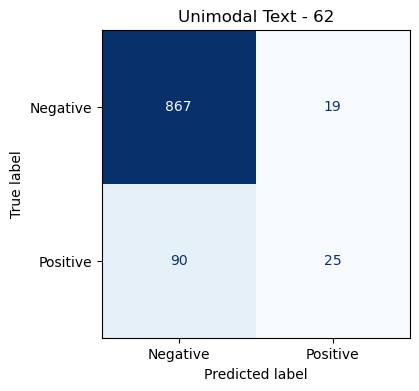


Unimodal Text - Class '63'
Confusion Matrix:
[[960   6]
 [ 22  13]]
Precision: 0.6842, Recall: 0.3714, F1-score: 0.4815


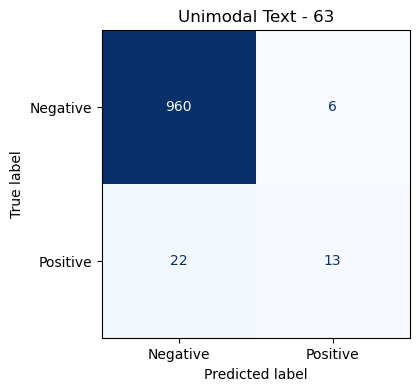


Unimodal Text - Class '64'
Confusion Matrix:
[[972   0]
 [ 28   1]]
Precision: 1.0000, Recall: 0.0345, F1-score: 0.0667


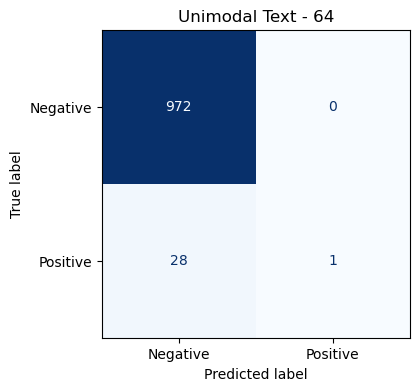


Unimodal Text - Class '65'
Confusion Matrix:
[[972   0]
 [ 23   6]]
Precision: 1.0000, Recall: 0.2069, F1-score: 0.3429


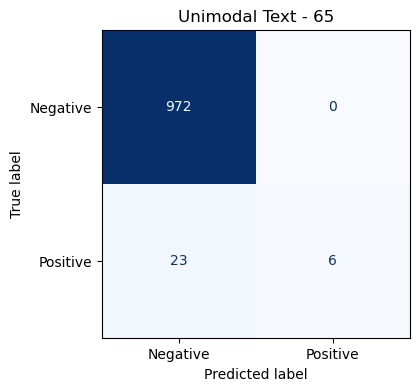


Unimodal Text - Class '67'
Confusion Matrix:
[[889  14]
 [ 54  44]]
Precision: 0.7586, Recall: 0.4490, F1-score: 0.5641


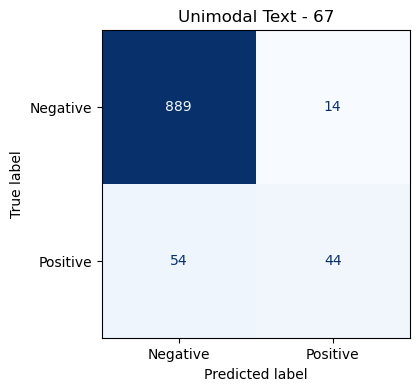


Unimodal Text - Class '70'
Confusion Matrix:
[[976   1]
 [ 11  13]]
Precision: 0.9286, Recall: 0.5417, F1-score: 0.6842


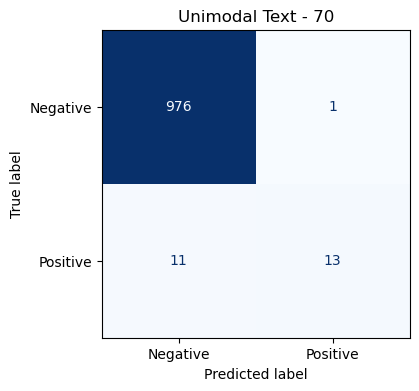


Unimodal Text - Class '72'
Confusion Matrix:
[[961   1]
 [ 32   7]]
Precision: 0.8750, Recall: 0.1795, F1-score: 0.2979


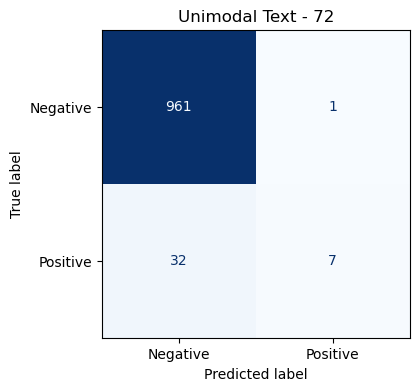


Unimodal Text - Class '73'
Confusion Matrix:
[[973   1]
 [ 17  10]]
Precision: 0.9091, Recall: 0.3704, F1-score: 0.5263


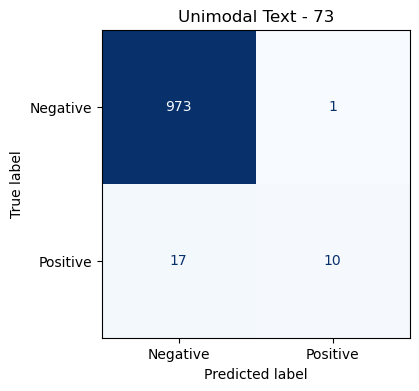


Unimodal Text - Class '74'
Confusion Matrix:
[[988   0]
 [  7   6]]
Precision: 1.0000, Recall: 0.4615, F1-score: 0.6316


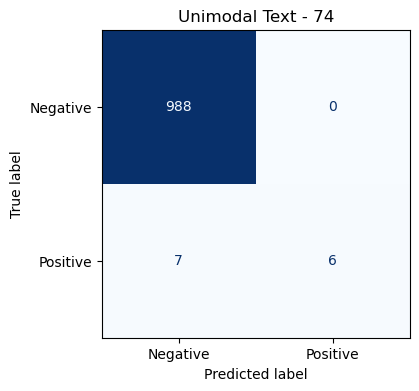


Unimodal Text - Class '75'
Confusion Matrix:
[[977   0]
 [ 15   9]]
Precision: 1.0000, Recall: 0.3750, F1-score: 0.5455


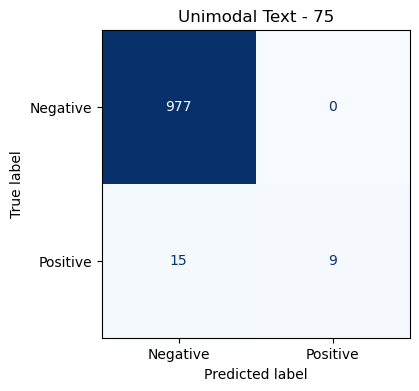


Unimodal Text - Class '76'
Confusion Matrix:
[[985   1]
 [  9   6]]
Precision: 0.8571, Recall: 0.4000, F1-score: 0.5455


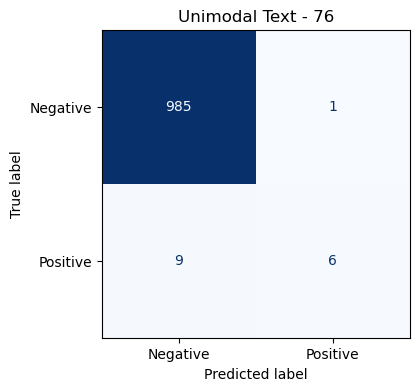


Unimodal Text - Class '77'
Confusion Matrix:
[[964   0]
 [ 25  12]]
Precision: 1.0000, Recall: 0.3243, F1-score: 0.4898


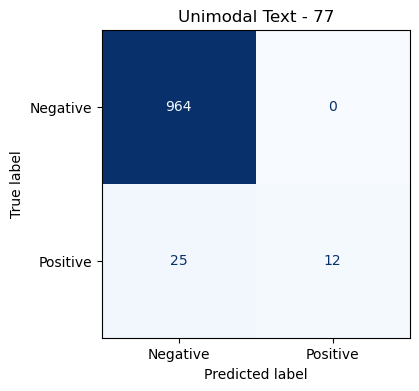


Unimodal Text - Class '78'
Confusion Matrix:
[[991   0]
 [ 10   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


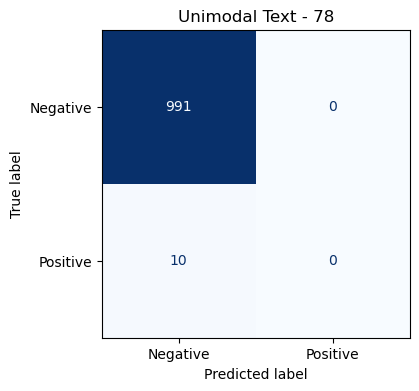


Unimodal Text - Class '79'
Confusion Matrix:
[[973   1]
 [ 21   6]]
Precision: 0.8571, Recall: 0.2222, F1-score: 0.3529


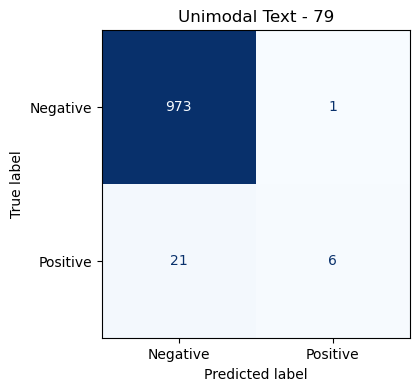


Unimodal Text - Class '80'
Confusion Matrix:
[[1000    0]
 [   1    0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


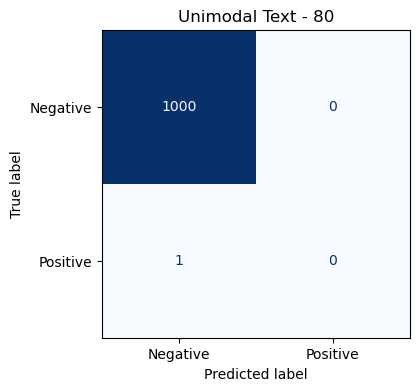


Unimodal Text - Class '81'
Confusion Matrix:
[[966   8]
 [ 16  11]]
Precision: 0.5789, Recall: 0.4074, F1-score: 0.4783


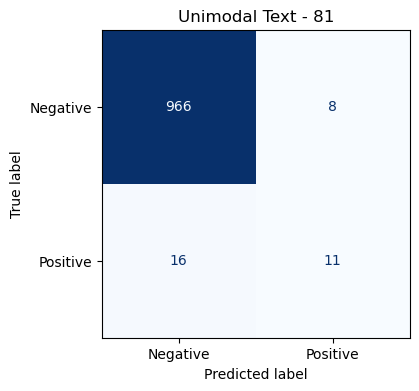


Unimodal Text - Class '82'
Confusion Matrix:
[[984   0]
 [ 17   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


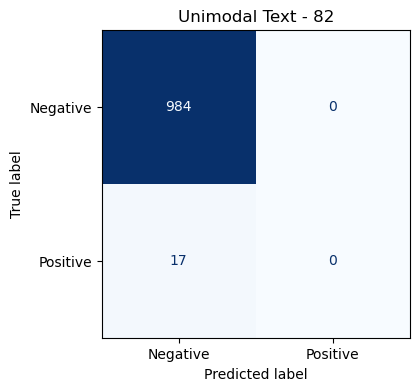


Unimodal Text - Class '84'
Confusion Matrix:
[[954   6]
 [ 39   2]]
Precision: 0.2500, Recall: 0.0488, F1-score: 0.0816


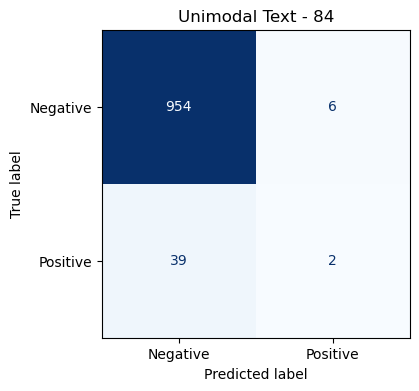


Unimodal Text - Class '85'
Confusion Matrix:
[[959   1]
 [ 29  12]]
Precision: 0.9231, Recall: 0.2927, F1-score: 0.4444


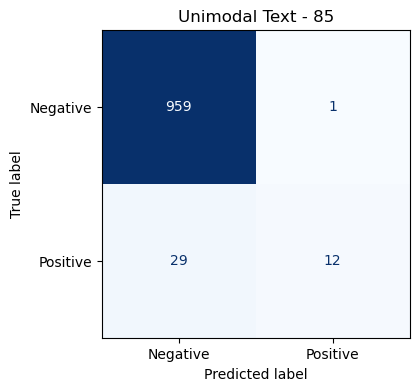


Unimodal Text - Class '86'
Confusion Matrix:
[[967   1]
 [ 32   1]]
Precision: 0.5000, Recall: 0.0303, F1-score: 0.0571


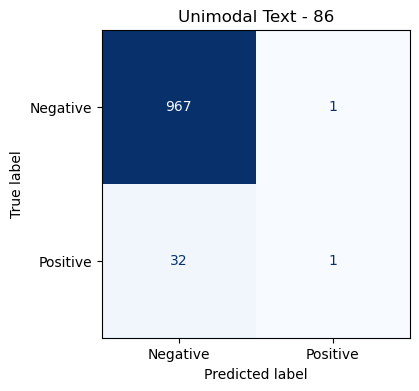


Unimodal Text - Class '87'
Confusion Matrix:
[[996   0]
 [  5   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


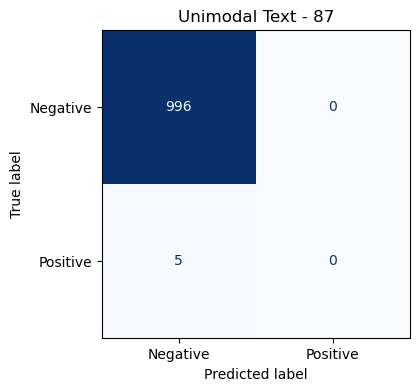


Unimodal Text - Class '88'
Confusion Matrix:
[[987   0]
 [ 12   2]]
Precision: 1.0000, Recall: 0.1429, F1-score: 0.2500


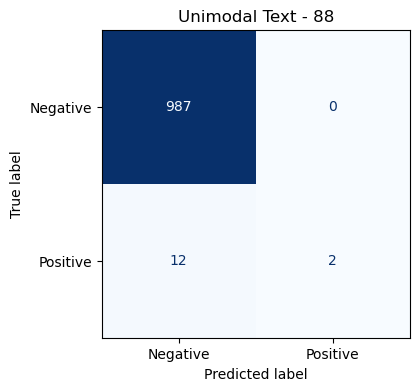


Unimodal Text - Class '89'
Confusion Matrix:
[[1001    0]
 [   0    0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


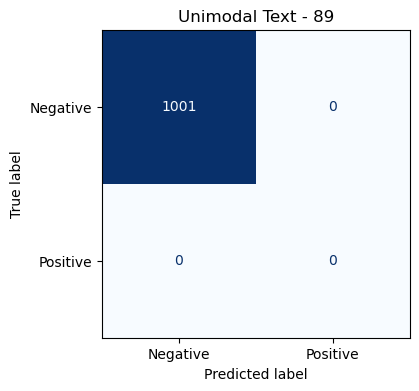


Unimodal Text - Class '90'
Confusion Matrix:
[[993   0]
 [  8   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


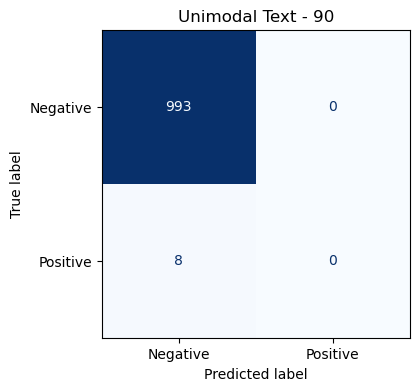


=== Multimodal Fused ===

Multimodal Fused - Class '1'
Confusion Matrix:
[[414  47]
 [ 93 447]]
Precision: 0.9049, Recall: 0.8278, F1-score: 0.8646


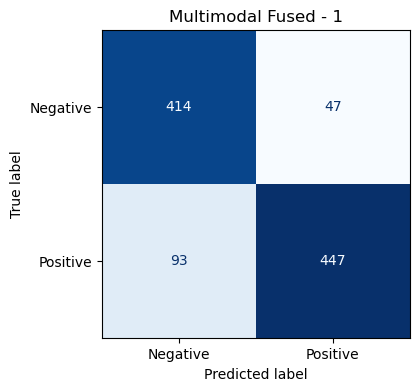


Multimodal Fused - Class '2'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


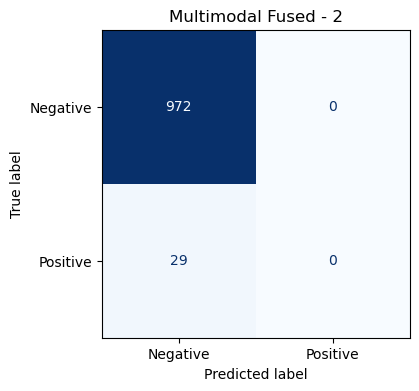


Multimodal Fused - Class '3'
Confusion Matrix:
[[885  15]
 [ 70  31]]
Precision: 0.6739, Recall: 0.3069, F1-score: 0.4218


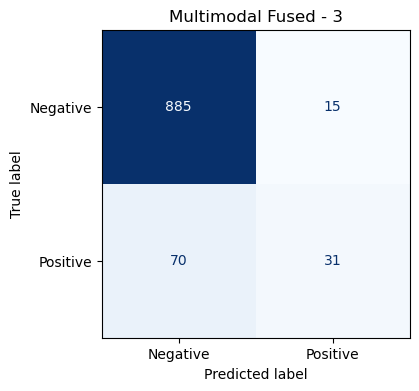


Multimodal Fused - Class '4'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


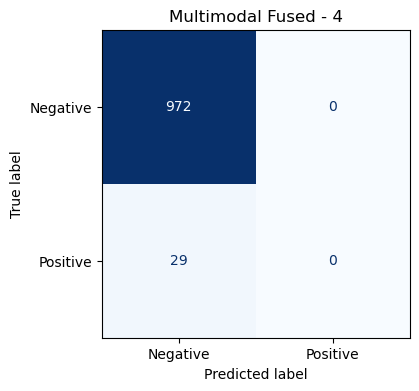


Multimodal Fused - Class '5'
Confusion Matrix:
[[981   1]
 [ 14   5]]
Precision: 0.8333, Recall: 0.2632, F1-score: 0.4000


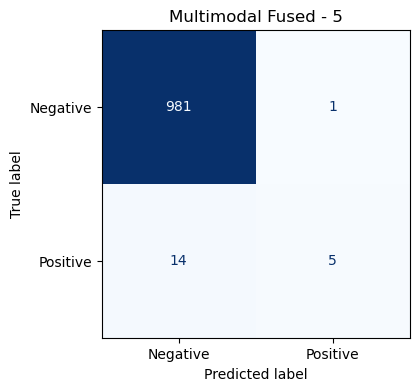


Multimodal Fused - Class '6'
Confusion Matrix:
[[959   2]
 [ 30  10]]
Precision: 0.8333, Recall: 0.2500, F1-score: 0.3846


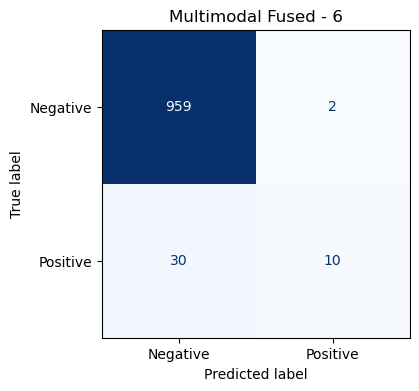


Multimodal Fused - Class '7'
Confusion Matrix:
[[969   0]
 [  9  23]]
Precision: 1.0000, Recall: 0.7188, F1-score: 0.8364


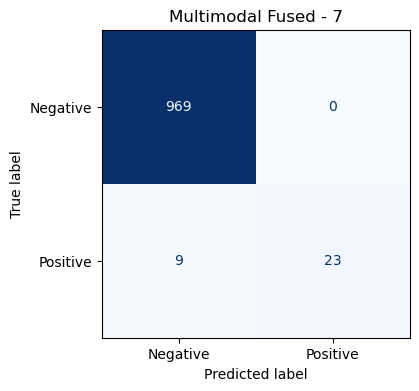


Multimodal Fused - Class '8'
Confusion Matrix:
[[957   0]
 [ 44   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


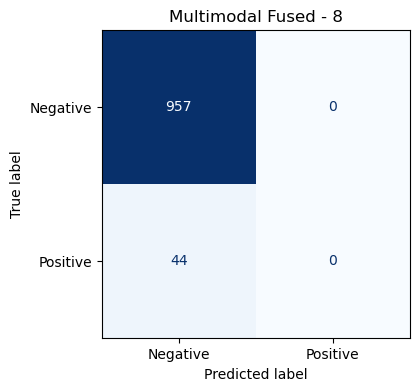


Multimodal Fused - Class '9'
Confusion Matrix:
[[978   0]
 [ 23   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


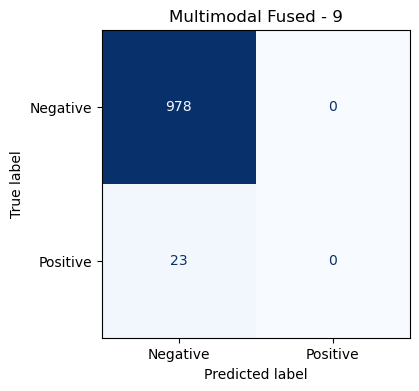


Multimodal Fused - Class '10'
Confusion Matrix:
[[953   4]
 [ 36   8]]
Precision: 0.6667, Recall: 0.1818, F1-score: 0.2857


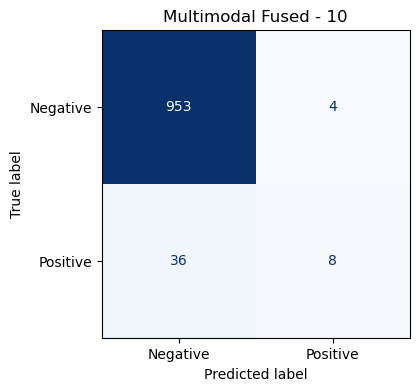


Multimodal Fused - Class '11'
Confusion Matrix:
[[985   0]
 [ 15   1]]
Precision: 1.0000, Recall: 0.0625, F1-score: 0.1176


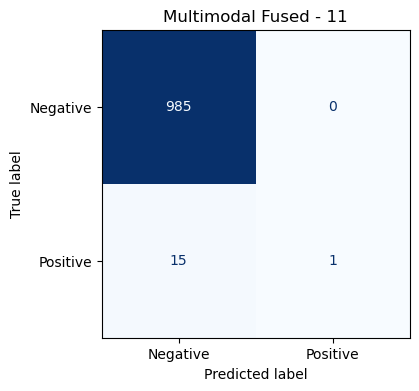


Multimodal Fused - Class '13'
Confusion Matrix:
[[984   0]
 [ 15   2]]
Precision: 1.0000, Recall: 0.1176, F1-score: 0.2105


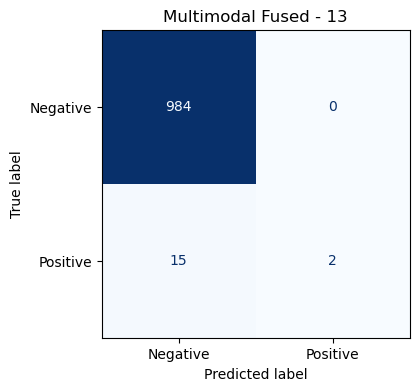


Multimodal Fused - Class '14'
Confusion Matrix:
[[995   0]
 [  6   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


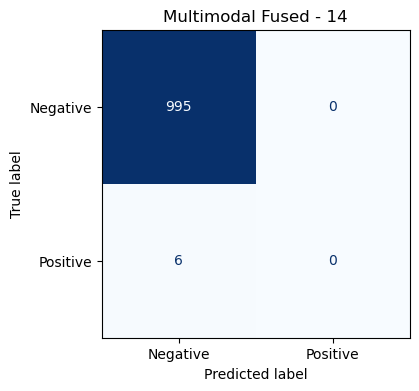


Multimodal Fused - Class '15'
Confusion Matrix:
[[952   0]
 [ 47   2]]
Precision: 1.0000, Recall: 0.0408, F1-score: 0.0784


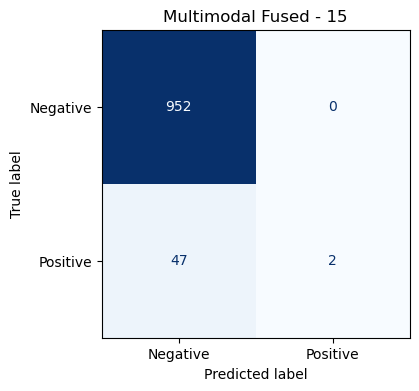


Multimodal Fused - Class '16'
Confusion Matrix:
[[980   0]
 [ 21   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


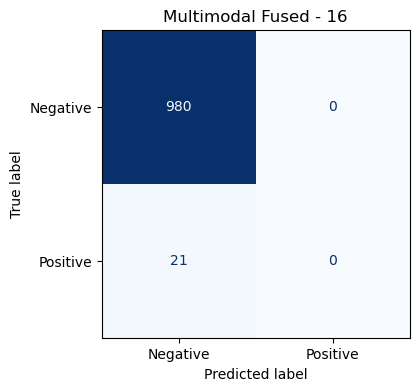


Multimodal Fused - Class '17'
Confusion Matrix:
[[968   1]
 [ 21  11]]
Precision: 0.9167, Recall: 0.3438, F1-score: 0.5000


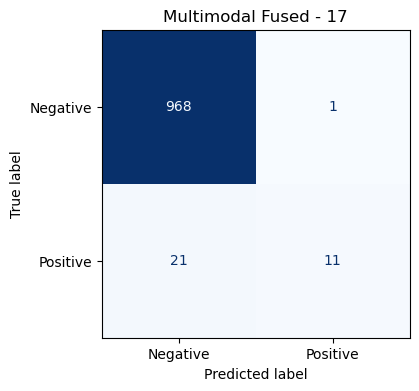


Multimodal Fused - Class '18'
Confusion Matrix:
[[966   0]
 [ 35   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


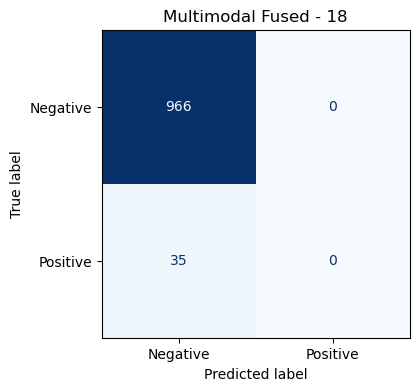


Multimodal Fused - Class '19'
Confusion Matrix:
[[979   0]
 [ 22   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


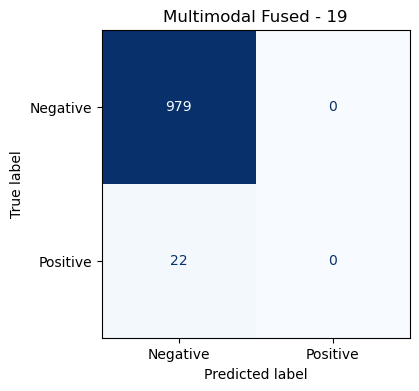


Multimodal Fused - Class '20'
Confusion Matrix:
[[986   0]
 [ 15   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


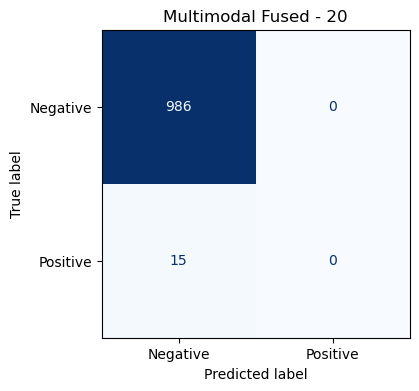


Multimodal Fused - Class '21'
Confusion Matrix:
[[980   0]
 [ 21   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


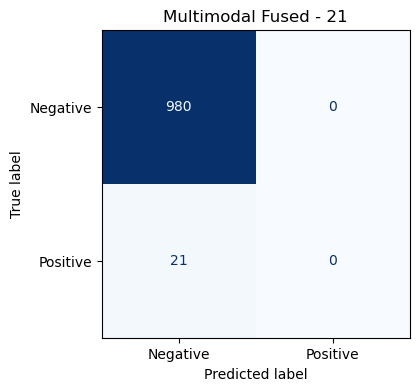


Multimodal Fused - Class '22'
Confusion Matrix:
[[981   0]
 [ 20   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


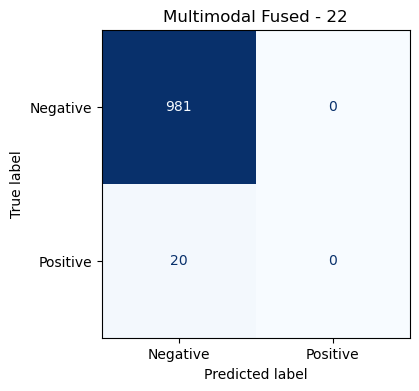


Multimodal Fused - Class '23'
Confusion Matrix:
[[988   0]
 [ 13   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


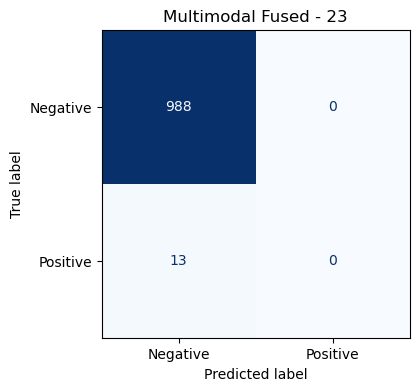


Multimodal Fused - Class '24'
Confusion Matrix:
[[978   2]
 [ 20   1]]
Precision: 0.3333, Recall: 0.0476, F1-score: 0.0833


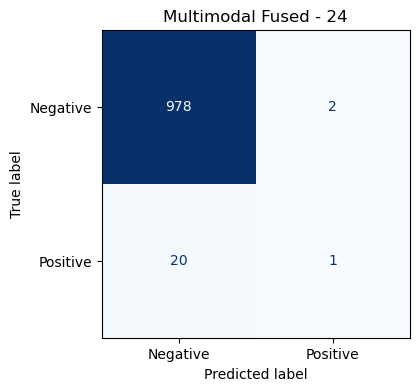


Multimodal Fused - Class '25'
Confusion Matrix:
[[982   0]
 [ 18   1]]
Precision: 1.0000, Recall: 0.0526, F1-score: 0.1000


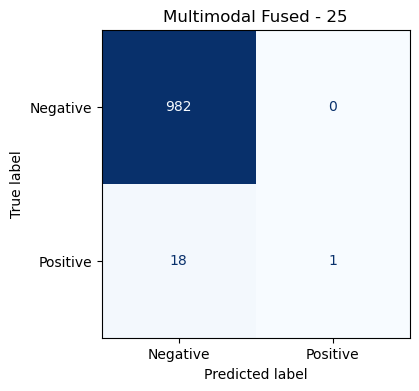


Multimodal Fused - Class '27'
Confusion Matrix:
[[955   0]
 [ 46   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


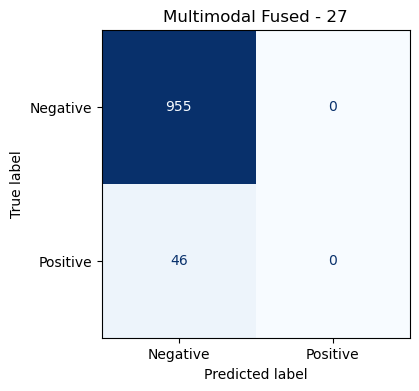


Multimodal Fused - Class '28'
Confusion Matrix:
[[971   0]
 [ 29   1]]
Precision: 1.0000, Recall: 0.0333, F1-score: 0.0645


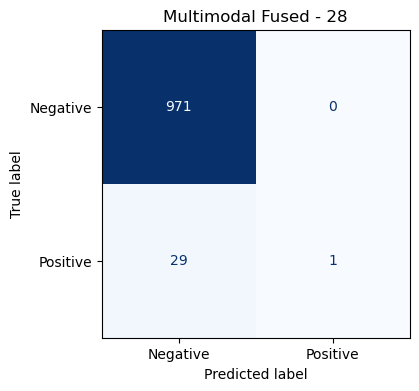


Multimodal Fused - Class '31'
Confusion Matrix:
[[945   0]
 [ 56   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


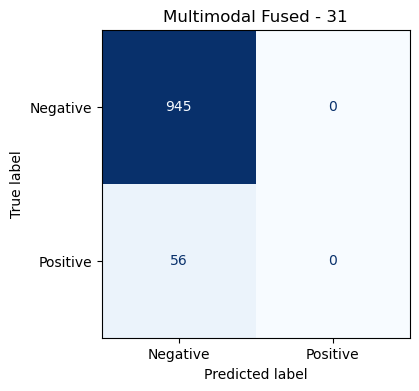


Multimodal Fused - Class '32'
Confusion Matrix:
[[970   0]
 [ 26   5]]
Precision: 1.0000, Recall: 0.1613, F1-score: 0.2778


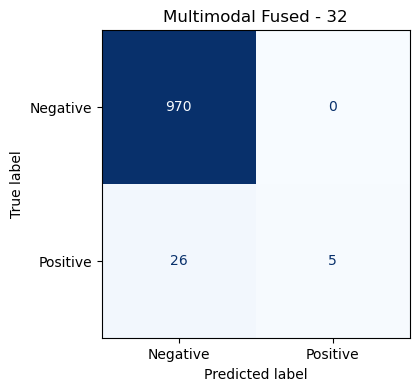


Multimodal Fused - Class '33'
Confusion Matrix:
[[976   0]
 [ 25   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


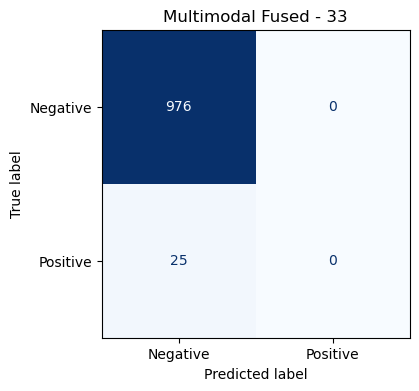


Multimodal Fused - Class '34'
Confusion Matrix:
[[982   0]
 [ 18   1]]
Precision: 1.0000, Recall: 0.0526, F1-score: 0.1000


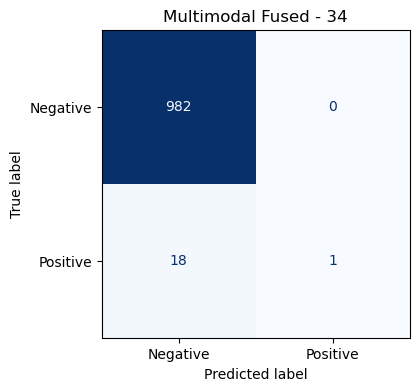


Multimodal Fused - Class '35'
Confusion Matrix:
[[977   1]
 [ 22   1]]
Precision: 0.5000, Recall: 0.0435, F1-score: 0.0800


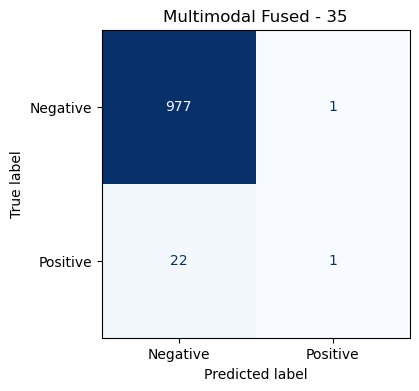


Multimodal Fused - Class '36'
Confusion Matrix:
[[990   0]
 [ 11   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


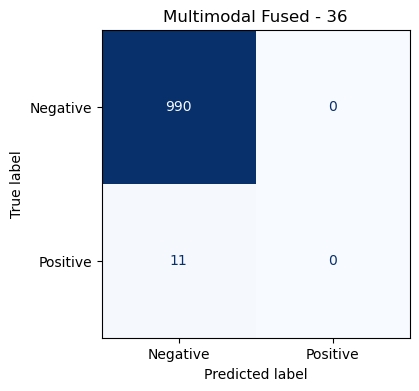


Multimodal Fused - Class '37'
Confusion Matrix:
[[950  14]
 [ 24  13]]
Precision: 0.4815, Recall: 0.3514, F1-score: 0.4062


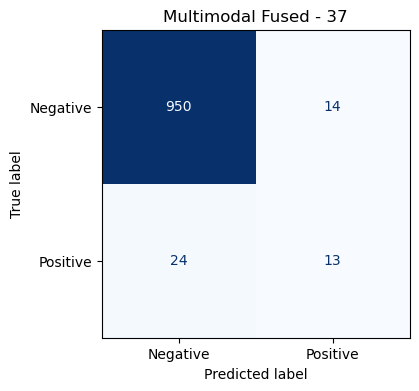


Multimodal Fused - Class '38'
Confusion Matrix:
[[984   0]
 [ 13   4]]
Precision: 1.0000, Recall: 0.2353, F1-score: 0.3810


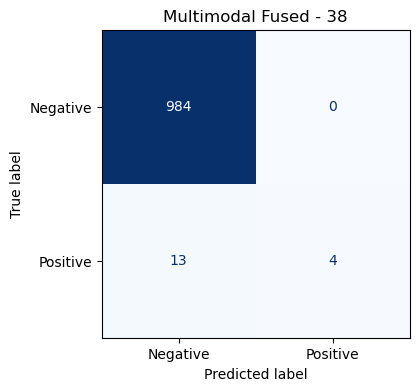


Multimodal Fused - Class '39'
Confusion Matrix:
[[980   0]
 [ 11  10]]
Precision: 1.0000, Recall: 0.4762, F1-score: 0.6452


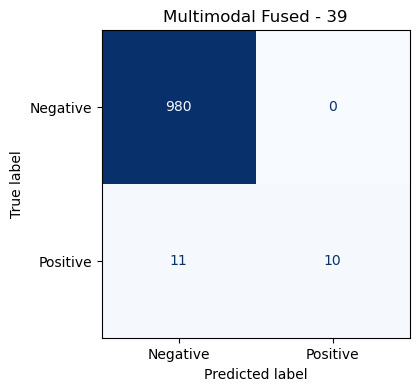


Multimodal Fused - Class '40'
Confusion Matrix:
[[984   2]
 [  7   8]]
Precision: 0.8000, Recall: 0.5333, F1-score: 0.6400


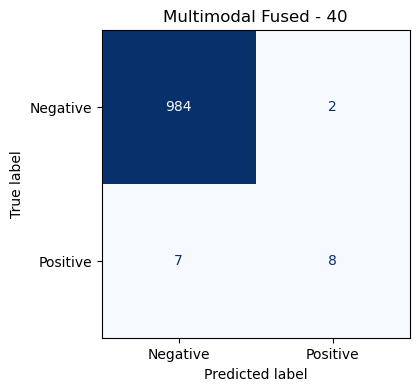


Multimodal Fused - Class '41'
Confusion Matrix:
[[978   0]
 [ 13  10]]
Precision: 1.0000, Recall: 0.4348, F1-score: 0.6061


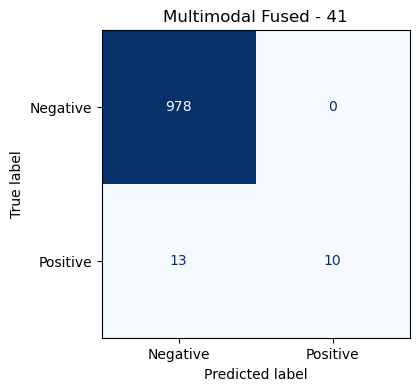


Multimodal Fused - Class '42'
Confusion Matrix:
[[966   0]
 [ 27   8]]
Precision: 1.0000, Recall: 0.2286, F1-score: 0.3721


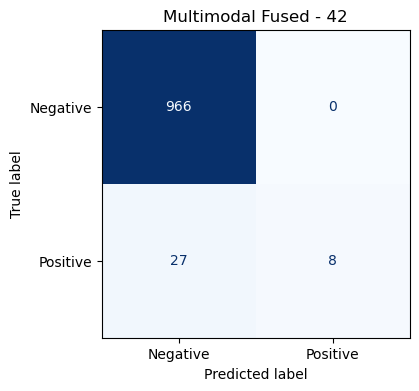


Multimodal Fused - Class '43'
Confusion Matrix:
[[962   0]
 [ 11  28]]
Precision: 1.0000, Recall: 0.7179, F1-score: 0.8358


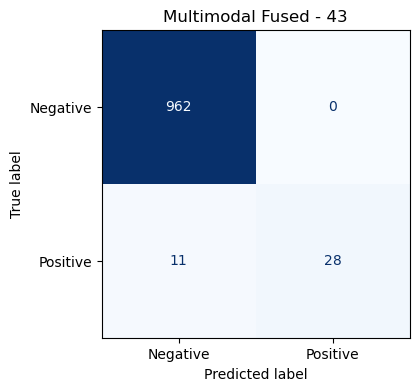


Multimodal Fused - Class '44'
Confusion Matrix:
[[932   1]
 [ 67   1]]
Precision: 0.5000, Recall: 0.0147, F1-score: 0.0286


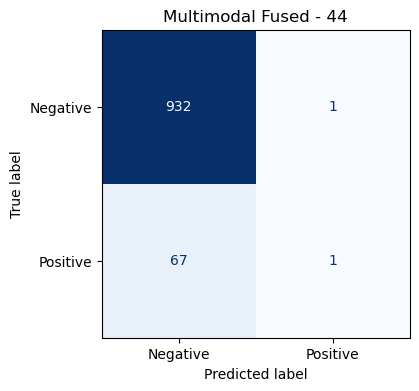


Multimodal Fused - Class '46'
Confusion Matrix:
[[983   0]
 [ 18   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


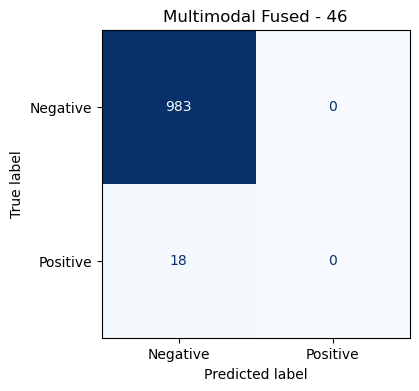


Multimodal Fused - Class '47'
Confusion Matrix:
[[921   1]
 [ 75   4]]
Precision: 0.8000, Recall: 0.0506, F1-score: 0.0952


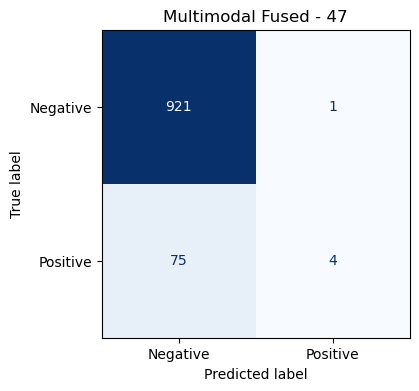


Multimodal Fused - Class '48'
Confusion Matrix:
[[974   0]
 [ 24   3]]
Precision: 1.0000, Recall: 0.1111, F1-score: 0.2000


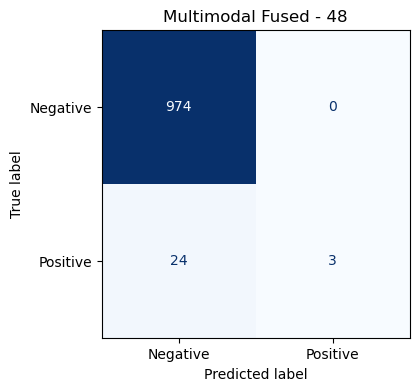


Multimodal Fused - Class '49'
Confusion Matrix:
[[965   0]
 [ 36   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


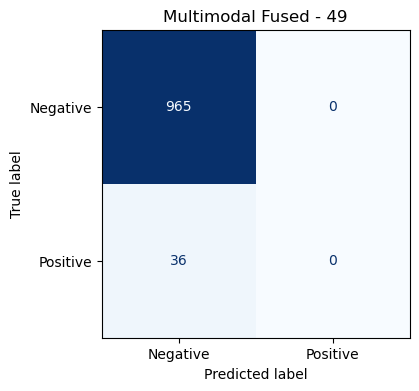


Multimodal Fused - Class '50'
Confusion Matrix:
[[969   0]
 [ 32   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


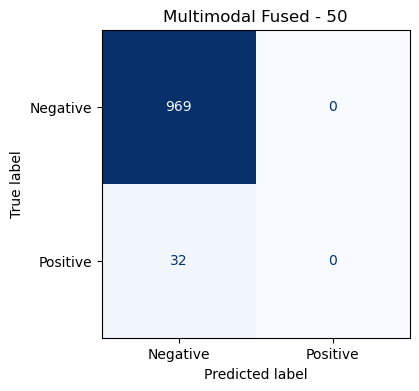


Multimodal Fused - Class '51'
Confusion Matrix:
[[931   3]
 [ 61   6]]
Precision: 0.6667, Recall: 0.0896, F1-score: 0.1579


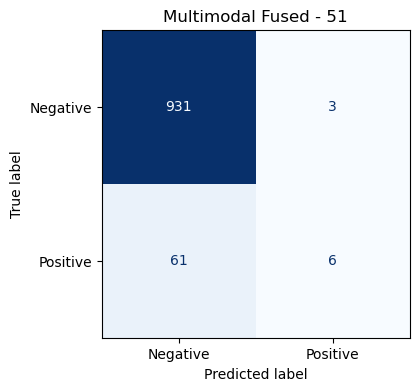


Multimodal Fused - Class '52'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


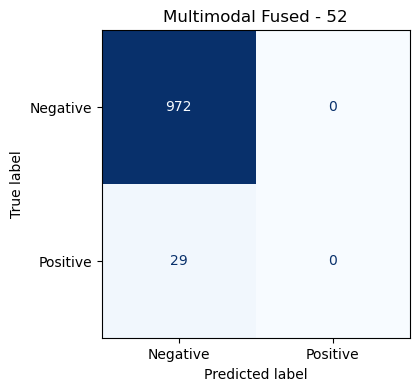


Multimodal Fused - Class '53'
Confusion Matrix:
[[984   0]
 [ 17   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


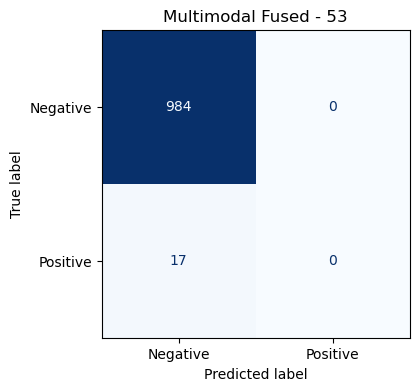


Multimodal Fused - Class '54'
Confusion Matrix:
[[979   0]
 [ 22   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


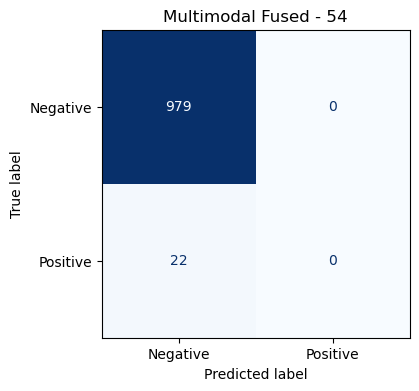


Multimodal Fused - Class '55'
Confusion Matrix:
[[983   0]
 [ 18   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


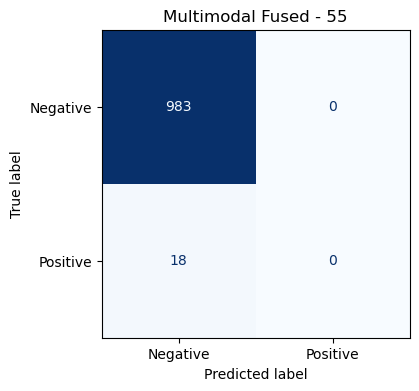


Multimodal Fused - Class '56'
Confusion Matrix:
[[989   0]
 [ 10   2]]
Precision: 1.0000, Recall: 0.1667, F1-score: 0.2857


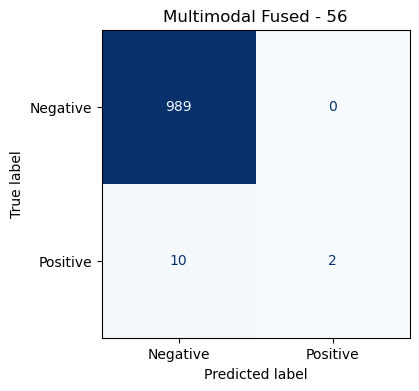


Multimodal Fused - Class '57'
Confusion Matrix:
[[981   0]
 [ 20   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


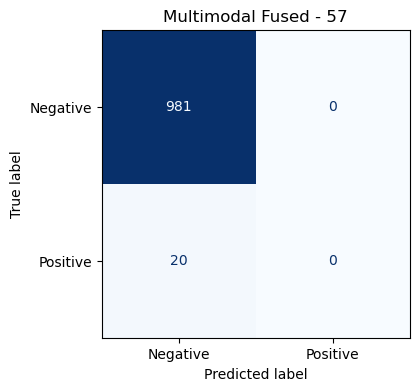


Multimodal Fused - Class '58'
Confusion Matrix:
[[991   0]
 [ 10   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


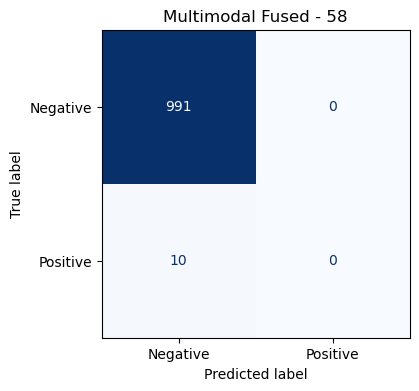


Multimodal Fused - Class '59'
Confusion Matrix:
[[966   0]
 [ 33   2]]
Precision: 1.0000, Recall: 0.0571, F1-score: 0.1081


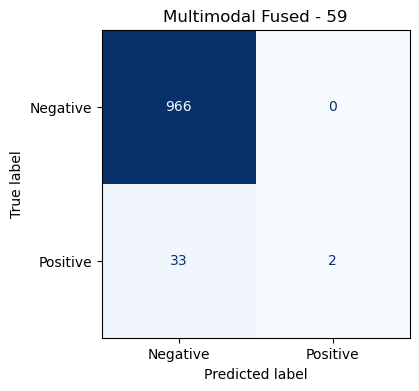


Multimodal Fused - Class '60'
Confusion Matrix:
[[987   0]
 [ 14   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


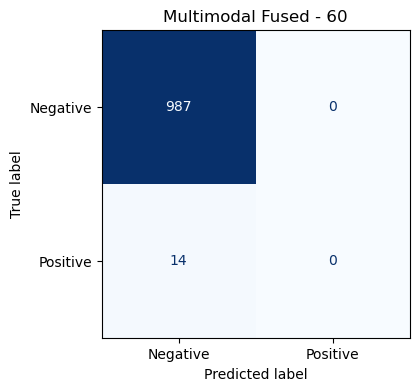


Multimodal Fused - Class '61'
Confusion Matrix:
[[973   0]
 [ 28   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


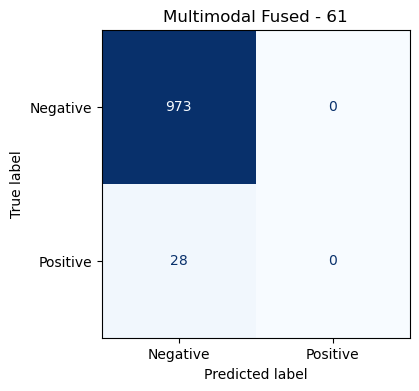


Multimodal Fused - Class '62'
Confusion Matrix:
[[875  11]
 [ 97  18]]
Precision: 0.6207, Recall: 0.1565, F1-score: 0.2500


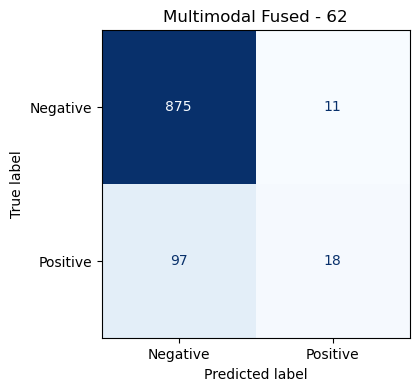


Multimodal Fused - Class '63'
Confusion Matrix:
[[964   2]
 [ 23  12]]
Precision: 0.8571, Recall: 0.3429, F1-score: 0.4898


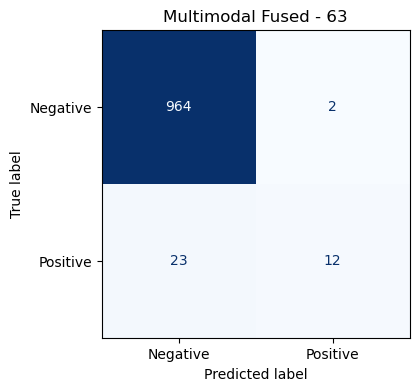


Multimodal Fused - Class '64'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


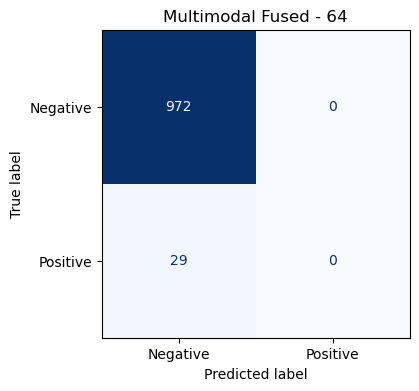


Multimodal Fused - Class '65'
Confusion Matrix:
[[972   0]
 [ 29   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


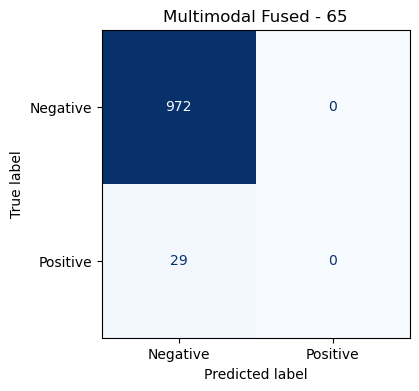


Multimodal Fused - Class '67'
Confusion Matrix:
[[892  11]
 [ 64  34]]
Precision: 0.7556, Recall: 0.3469, F1-score: 0.4755


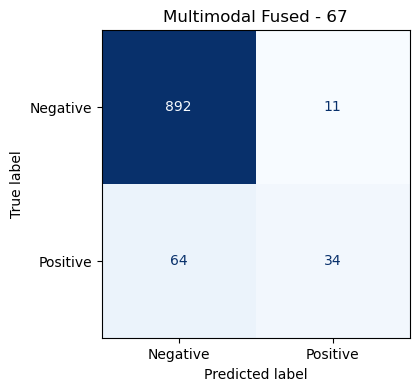


Multimodal Fused - Class '70'
Confusion Matrix:
[[976   1]
 [ 13  11]]
Precision: 0.9167, Recall: 0.4583, F1-score: 0.6111


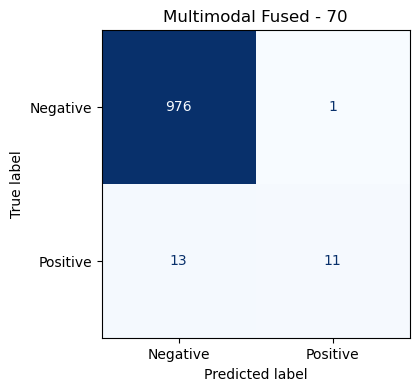


Multimodal Fused - Class '72'
Confusion Matrix:
[[961   1]
 [ 37   2]]
Precision: 0.6667, Recall: 0.0513, F1-score: 0.0952


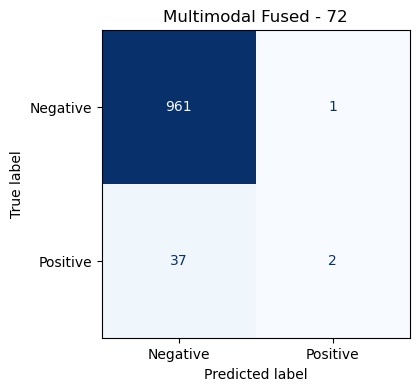


Multimodal Fused - Class '73'
Confusion Matrix:
[[973   1]
 [ 21   6]]
Precision: 0.8571, Recall: 0.2222, F1-score: 0.3529


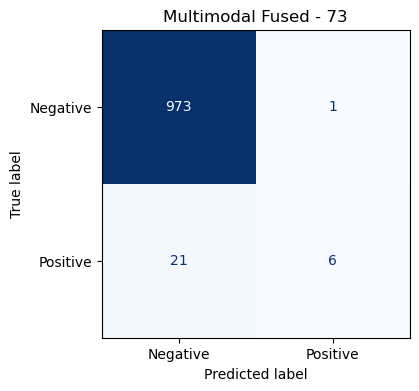


Multimodal Fused - Class '74'
Confusion Matrix:
[[988   0]
 [  9   4]]
Precision: 1.0000, Recall: 0.3077, F1-score: 0.4706


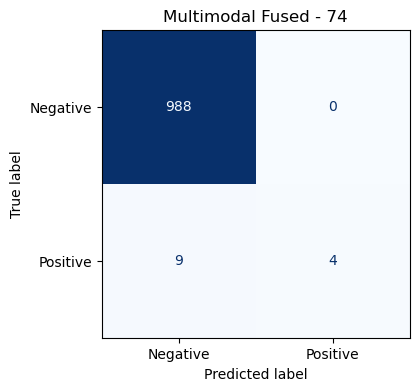


Multimodal Fused - Class '75'
Confusion Matrix:
[[977   0]
 [ 16   8]]
Precision: 1.0000, Recall: 0.3333, F1-score: 0.5000


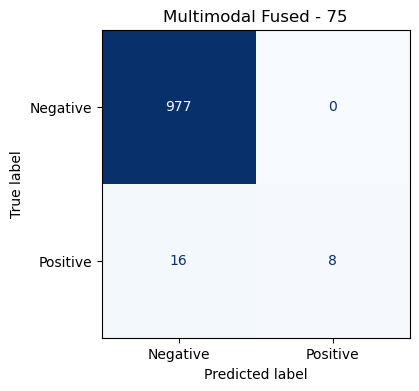


Multimodal Fused - Class '76'
Confusion Matrix:
[[985   1]
 [ 11   4]]
Precision: 0.8000, Recall: 0.2667, F1-score: 0.4000


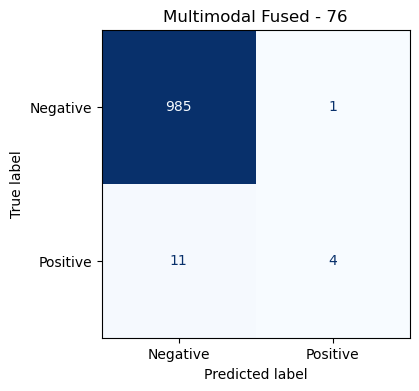


Multimodal Fused - Class '77'
Confusion Matrix:
[[964   0]
 [ 34   3]]
Precision: 1.0000, Recall: 0.0811, F1-score: 0.1500


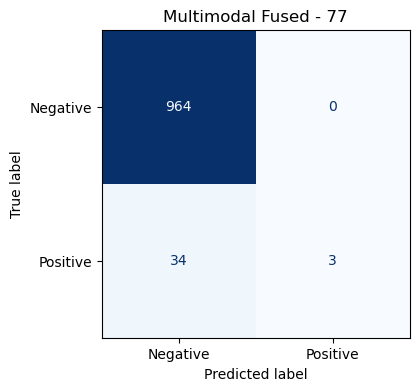


Multimodal Fused - Class '78'
Confusion Matrix:
[[991   0]
 [ 10   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


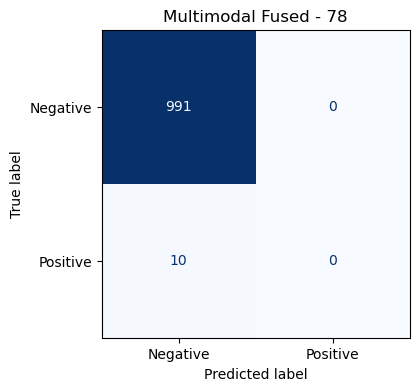


Multimodal Fused - Class '79'
Confusion Matrix:
[[974   0]
 [ 26   1]]
Precision: 1.0000, Recall: 0.0370, F1-score: 0.0714


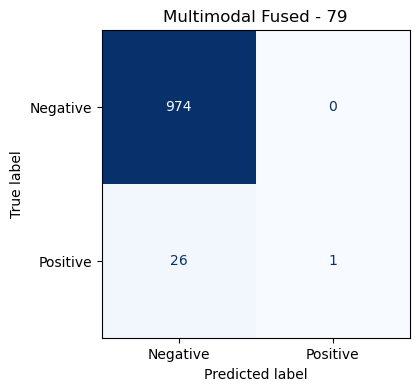


Multimodal Fused - Class '80'
Confusion Matrix:
[[1000    0]
 [   1    0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


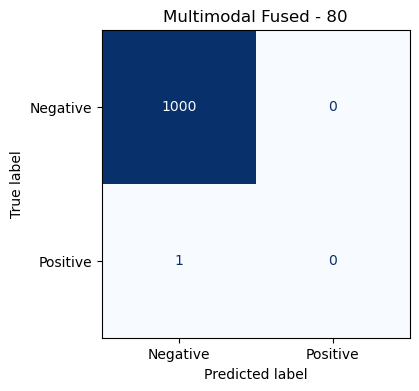


Multimodal Fused - Class '81'
Confusion Matrix:
[[969   5]
 [ 18   9]]
Precision: 0.6429, Recall: 0.3333, F1-score: 0.4390


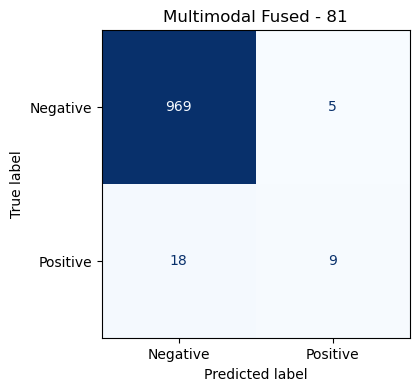


Multimodal Fused - Class '82'
Confusion Matrix:
[[984   0]
 [ 17   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


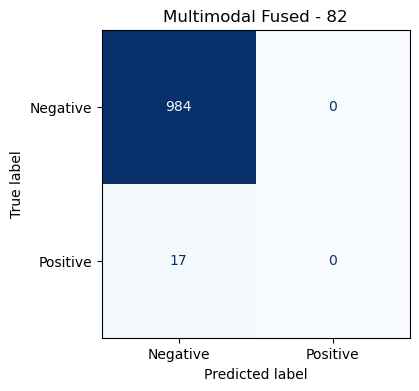


Multimodal Fused - Class '84'
Confusion Matrix:
[[958   2]
 [ 40   1]]
Precision: 0.3333, Recall: 0.0244, F1-score: 0.0455


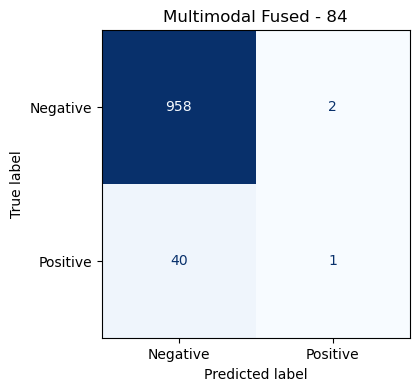


Multimodal Fused - Class '85'
Confusion Matrix:
[[960   0]
 [ 31  10]]
Precision: 1.0000, Recall: 0.2439, F1-score: 0.3922


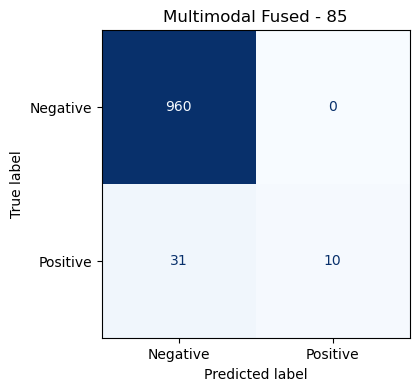


Multimodal Fused - Class '86'
Confusion Matrix:
[[968   0]
 [ 33   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


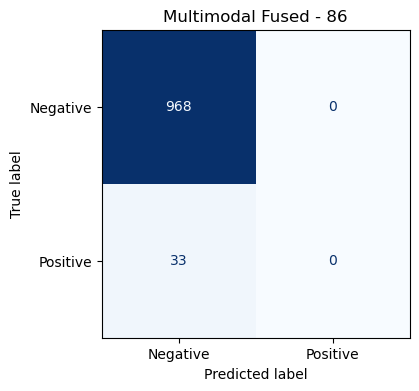


Multimodal Fused - Class '87'
Confusion Matrix:
[[996   0]
 [  5   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


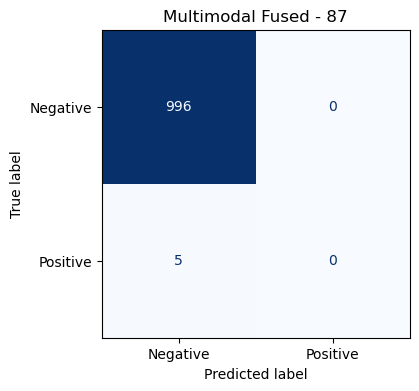


Multimodal Fused - Class '88'
Confusion Matrix:
[[987   0]
 [ 14   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


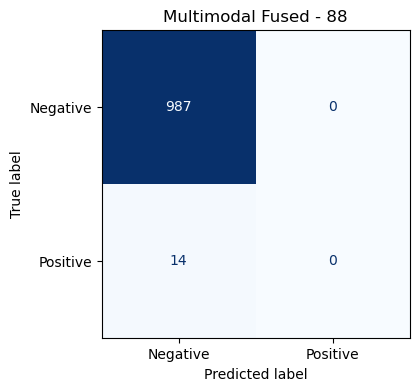


Multimodal Fused - Class '89'
Confusion Matrix:
[[1001    0]
 [   0    0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


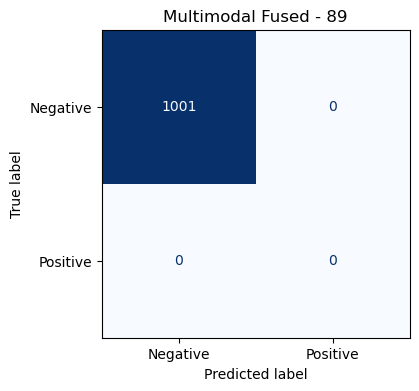


Multimodal Fused - Class '90'
Confusion Matrix:
[[993   0]
 [  8   0]]
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


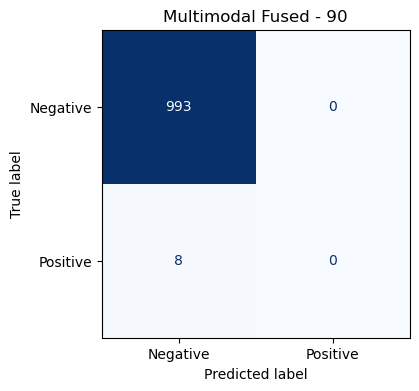

In [9]:
def plot_confusion_matrices_and_metrics(y_true, y_pred, class_names, title_prefix=""):
    num_classes = y_true.shape[1]
    
    if len(class_names) < num_classes:
        class_names = class_names + [f"Class_{i}" for i in range(len(class_names), num_classes)]
    elif len(class_names) > num_classes:
        class_names = class_names[:num_classes]

    for i in range(num_classes):
        binary_true = y_true[:, i]
        binary_pred = y_pred[:, i]

        # Force 2x2 matrix
        cm = confusion_matrix(binary_true, binary_pred, labels=[0, 1])

        precision = precision_score(binary_true, binary_pred, zero_division=0)
        recall = recall_score(binary_true, binary_pred, zero_division=0)
        f1 = f1_score(binary_true, binary_pred, zero_division=0)

        print(f"\n{title_prefix} - Class '{class_names[i]}'")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
        fig, ax = plt.subplots(figsize=(4, 4))
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
        plt.title(f"{title_prefix} - {class_names[i]}")
        plt.show()

# Example usage after predictions
class_names = list(mlb.classes_)  # map category ids to names

print("\n=== Unimodal Image ===")
plot_confusion_matrices_and_metrics(y_test, pred_img, class_names, title_prefix="Unimodal Image")

print("\n=== Unimodal Text ===")
plot_confusion_matrices_and_metrics(y_test, pred_text, class_names, title_prefix="Unimodal Text")

print("\n=== Multimodal Fused ===")
plot_confusion_matrices_and_metrics(y_test, pred_fused, class_names, title_prefix="Multimodal Fused")


**9. Example Prediction**

In [10]:
import pandas as pd

# Convert binary arrays back to lists of category IDs
true_labels_ids = mlb.inverse_transform(y_test)
pred_img_ids = mlb.inverse_transform(pred_img)
pred_text_ids = mlb.inverse_transform(pred_text)
pred_fused_ids = mlb.inverse_transform(pred_fused)

# Map IDs → category names
def ids_to_names(id_list):
    return [cat_id_to_name[i] for i in id_list]

true_labels = [ids_to_names(ids) for ids in true_labels_ids]
pred_img_labels = [ids_to_names(ids) for ids in pred_img_ids]
pred_text_labels = [ids_to_names(ids) for ids in pred_text_ids]
pred_fused_labels = [ids_to_names(ids) for ids in pred_fused_ids]

# Build example DataFrame
examples = pd.DataFrame({
    "filename": image_ids[:10],                # first 10 test images (adjust indexing)
    "caption": [" ".join(captions[i]) for i in range(10)],  # example captions
    "true_labels": true_labels[:10],
    "pred_img": pred_img_labels[:10],
    "pred_text": pred_text_labels[:10],
    "pred_fused": pred_fused_labels[:10],
})

print(examples)

           filename                                            caption  \
0  000000289229.jpg  a black honda motorcycle parked in front of a ...   
1  000000290768.jpg      a honda motorcycle parked in a grass driveway   
2  000000378139.jpg  an office cubicle with four different types of...   
3  000000292225.jpg           a small closed toilet in a cramped space   
4  000000066771.jpg      two women waiting at a bench next to a street   
5  000000384651.jpg  a black honda motorcycle with a dark burgundy ...   
6  000000394328.jpg  a tan toilet and sink combination in a small room   
7  000000520707.jpg   the home office space seems to be very cluttered   
8  000000345361.jpg  a beautiful dessert waiting to be shared by tw...   
9  000000016451.jpg  a woman sitting on a bench and a woman standin...   

                                 true_labels  pred_img  \
0        [sandwich, mouse, remote, keyboard]  [person]   
1      [person, backpack, umbrella, handbag]        []   
2          